## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

LABELS = [    
    "normal", "anomaly"
] 

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/Normalize/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(6694, 8, 36) (26632, 1) 1.3262511e-09 27.352802

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(2,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
training_iters = training_data_count *512
# training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 1.928609, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8928791284561157, Accuracy = 0.6322093605995178
Iter #512:  Learning rate = 0.005000:   Batch Loss = 1.764454, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.762908697128296, Accuracy = 0.65211021900177
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 1.928390, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.649980068206787, Accuracy = 0.759687602519989
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 1.730324, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5842474699020386, Accuracy = 0.7642685770988464
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 1.492121, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5496623516082764, Accuracy = 0.7655451893806458
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 1.583452, Accuracy = 0.78125
PERFORMANC

Iter #23040:  Learning rate = 0.005000:   Batch Loss = 1.034343, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.002208948135376, Accuracy = 0.8398167490959167
Iter #23552:  Learning rate = 0.005000:   Batch Loss = 1.002407, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0318710803985596, Accuracy = 0.8228822350502014
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 0.828992, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0344905853271484, Accuracy = 0.8068113327026367
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 0.971406, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0181509256362915, Accuracy = 0.8235206007957458
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 0.942348, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9387723207473755, Accuracy = 0.8508561253547668
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 0.840520, Accuracy = 

Iter #46080:  Learning rate = 0.005000:   Batch Loss = 0.602583, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8105641007423401, Accuracy = 0.8630970120429993
Iter #46592:  Learning rate = 0.005000:   Batch Loss = 0.811317, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8281077146530151, Accuracy = 0.8488284945487976
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 0.638320, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7904800772666931, Accuracy = 0.8503679633140564
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 0.612924, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7616368532180786, Accuracy = 0.8619329929351807
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 0.684511, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7839469909667969, Accuracy = 0.8543856739997864
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 0.569474, Accuracy = 0.9

Iter #69120:  Learning rate = 0.005000:   Batch Loss = 0.699773, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.695146918296814, Accuracy = 0.8738359808921814
Iter #69632:  Learning rate = 0.005000:   Batch Loss = 0.619859, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7500243186950684, Accuracy = 0.8526960015296936
Iter #70144:  Learning rate = 0.005000:   Batch Loss = 0.473822, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7882240414619446, Accuracy = 0.8304671049118042
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 0.607090, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7267425060272217, Accuracy = 0.8492414951324463
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 0.655218, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6869316101074219, Accuracy = 0.8704190254211426
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 0.501929, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 0.6487206220626831, Accuracy = 0.8832231760025024
Iter #92672:  Learning rate = 0.005000:   Batch Loss = 0.490209, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.697606086730957, Accuracy = 0.879092812538147
Iter #93184:  Learning rate = 0.005000:   Batch Loss = 0.454201, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6958203315734863, Accuracy = 0.8757885098457336
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 0.602669, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6803653240203857, Accuracy = 0.8826599717140198
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 0.485833, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6957701444625854, Accuracy = 0.8777410387992859
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 0.602824, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6592206358909607, Accuracy = 

Iter #115200:  Learning rate = 0.004800:   Batch Loss = 0.474654, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6328032612800598, Accuracy = 0.8859267234802246
Iter #115712:  Learning rate = 0.004800:   Batch Loss = 0.348009, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6360259056091309, Accuracy = 0.889080822467804
Iter #116224:  Learning rate = 0.004800:   Batch Loss = 0.439158, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6028658151626587, Accuracy = 0.8909582495689392
Iter #116736:  Learning rate = 0.004800:   Batch Loss = 0.488646, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5772947072982788, Accuracy = 0.8907704949378967
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 0.322897, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5820804834365845, Accuracy = 0.8801066279411316
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 0.356701, Accura

Iter #138240:  Learning rate = 0.004800:   Batch Loss = 0.360264, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5850797891616821, Accuracy = 0.898468017578125
Iter #138752:  Learning rate = 0.004800:   Batch Loss = 0.375113, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5617906451225281, Accuracy = 0.8939996957778931
Iter #139264:  Learning rate = 0.004800:   Batch Loss = 0.423448, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6299092769622803, Accuracy = 0.8742490410804749
Iter #139776:  Learning rate = 0.004800:   Batch Loss = 0.316021, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.550910472869873, Accuracy = 0.8923475742340088
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 0.258833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5012569427490234, Accuracy = 0.9098828434944153
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 0.299779, Accuracy = 0.9

Iter #160768:  Learning rate = 0.004800:   Batch Loss = 0.396622, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.580339789390564, Accuracy = 0.8970786929130554
Iter #161280:  Learning rate = 0.004800:   Batch Loss = 0.273412, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.604110598564148, Accuracy = 0.8871282935142517
Iter #161792:  Learning rate = 0.004800:   Batch Loss = 0.432290, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5982663035392761, Accuracy = 0.8910333514213562
Iter #162304:  Learning rate = 0.004800:   Batch Loss = 0.368749, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5427194833755493, Accuracy = 0.898392915725708
Iter #162816:  Learning rate = 0.004800:   Batch Loss = 0.308523, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5507634878158569, Accuracy = 0.8947882056236267
Iter #163328:  Learning rate = 0.004800:   Batch Loss = 0.312225, Accurac

Iter #183296:  Learning rate = 0.004800:   Batch Loss = 0.322871, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5608214735984802, Accuracy = 0.902185320854187
Iter #183808:  Learning rate = 0.004800:   Batch Loss = 0.298686, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4972653388977051, Accuracy = 0.9114974737167358
Iter #184320:  Learning rate = 0.004800:   Batch Loss = 0.279978, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5013278722763062, Accuracy = 0.9072169065475464
Iter #184832:  Learning rate = 0.004800:   Batch Loss = 0.273724, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.587655782699585, Accuracy = 0.8914088606834412
Iter #185344:  Learning rate = 0.004800:   Batch Loss = 0.283734, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5420441627502441, Accuracy = 0.9060153365135193
Iter #185856:  Learning rate = 0.004800:   Batch Loss = 0.272329, Accura

Iter #205824:  Learning rate = 0.004608:   Batch Loss = 0.273981, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5003207325935364, Accuracy = 0.9094697833061218
Iter #206336:  Learning rate = 0.004608:   Batch Loss = 0.206687, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47715461254119873, Accuracy = 0.9075172543525696
Iter #206848:  Learning rate = 0.004608:   Batch Loss = 0.429201, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6351059675216675, Accuracy = 0.8761640191078186
Iter #207360:  Learning rate = 0.004608:   Batch Loss = 0.294006, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5590060949325562, Accuracy = 0.8835611343383789
Iter #207872:  Learning rate = 0.004608:   Batch Loss = 0.299190, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46496716141700745, Accuracy = 0.9170546531677246
Iter #208384:  Learning rate = 0.004608:   Batch Loss = 0.216661, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.5900672078132629, Accuracy = 0.8963652849197388
Iter #228864:  Learning rate = 0.004608:   Batch Loss = 0.294840, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4971790611743927, Accuracy = 0.9122859835624695
Iter #229376:  Learning rate = 0.004608:   Batch Loss = 0.364699, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5324587821960449, Accuracy = 0.9027485847473145
Iter #229888:  Learning rate = 0.004608:   Batch Loss = 0.198961, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4886358380317688, Accuracy = 0.9127365350723267
Iter #230400:  Learning rate = 0.004608:   Batch Loss = 0.231741, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5454049706459045, Accuracy = 0.907930314540863
Iter #230912:  Learning rate = 0.004608:   Batch Loss = 0.273885, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5787791609764099, Accuracy 

Iter #251392:  Learning rate = 0.004608:   Batch Loss = 0.186329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5548160672187805, Accuracy = 0.9018849730491638
Iter #251904:  Learning rate = 0.004608:   Batch Loss = 0.291087, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6030282974243164, Accuracy = 0.8906202912330627
Iter #252416:  Learning rate = 0.004608:   Batch Loss = 0.176729, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5609872937202454, Accuracy = 0.888480007648468
Iter #252928:  Learning rate = 0.004608:   Batch Loss = 0.257306, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.587486743927002, Accuracy = 0.8758260607719421
Iter #253440:  Learning rate = 0.004608:   Batch Loss = 0.209531, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4971911311149597, Accuracy = 0.9016972184181213
Iter #253952:  Learning rate = 0.004608:   Batch Loss = 0.264836, Accuracy = 0.953125
PE

Iter #274432:  Learning rate = 0.004608:   Batch Loss = 0.217061, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.516902506351471, Accuracy = 0.9087939262390137
Iter #274944:  Learning rate = 0.004608:   Batch Loss = 0.176624, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5279113054275513, Accuracy = 0.9102208018302917
Iter #275456:  Learning rate = 0.004608:   Batch Loss = 0.299559, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5861175060272217, Accuracy = 0.9063156843185425
Iter #275968:  Learning rate = 0.004608:   Batch Loss = 0.290403, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5866825580596924, Accuracy = 0.9061655402183533
Iter #276480:  Learning rate = 0.004608:   Batch Loss = 0.240238, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5842011570930481, Accuracy = 0.9015470147132874
Iter #276992:  Learning rate = 0.004608:   Batch Loss = 0.177804, Accuracy = 

Iter #297472:  Learning rate = 0.004608:   Batch Loss = 0.299125, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.585878849029541, Accuracy = 0.9015470147132874
Iter #297984:  Learning rate = 0.004608:   Batch Loss = 0.163174, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5505188703536987, Accuracy = 0.9041378498077393
Iter #298496:  Learning rate = 0.004608:   Batch Loss = 0.221015, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5824875831604004, Accuracy = 0.8960648775100708
Iter #299008:  Learning rate = 0.004608:   Batch Loss = 0.182120, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.551318883895874, Accuracy = 0.9013592600822449
Iter #299520:  Learning rate = 0.004608:   Batch Loss = 0.192648, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5416545271873474, Accuracy = 0.9013592600822449
Iter #300032:  Learning rate = 0.004424:   Batch Loss = 0.166654, Accuracy = 1.0

Iter #320512:  Learning rate = 0.004424:   Batch Loss = 0.177201, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4852745532989502, Accuracy = 0.9098828434944153
Iter #321024:  Learning rate = 0.004424:   Batch Loss = 0.239992, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4694434404373169, Accuracy = 0.9129993915557861
Iter #321536:  Learning rate = 0.004424:   Batch Loss = 0.205825, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4817034602165222, Accuracy = 0.9086061716079712
Iter #322048:  Learning rate = 0.004424:   Batch Loss = 0.160839, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5220242142677307, Accuracy = 0.902635931968689
Iter #322560:  Learning rate = 0.004424:   Batch Loss = 0.188003, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47253328561782837, Accuracy = 0.9126238822937012
Iter #323072:  Learning rate = 0.004424:   Batch Loss = 0.187694, Accuracy =

Iter #343552:  Learning rate = 0.004424:   Batch Loss = 0.169017, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4899252653121948, Accuracy = 0.9109342098236084
Iter #344064:  Learning rate = 0.004424:   Batch Loss = 0.174883, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5294093489646912, Accuracy = 0.9053394198417664
Iter #344576:  Learning rate = 0.004424:   Batch Loss = 0.241614, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5261954069137573, Accuracy = 0.9072169065475464
Iter #345088:  Learning rate = 0.004424:   Batch Loss = 0.204310, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48194313049316406, Accuracy = 0.9099954962730408
Iter #345600:  Learning rate = 0.004424:   Batch Loss = 0.212977, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6676612496376038, Accuracy = 0.8613322377204895
Iter #346112:  Learning rate = 0.004424:   Batch Loss = 0.295897, Accuracy 

Iter #366592:  Learning rate = 0.004424:   Batch Loss = 0.192549, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4692472815513611, Accuracy = 0.9079678654670715
Iter #367104:  Learning rate = 0.004424:   Batch Loss = 0.141318, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4590199589729309, Accuracy = 0.9113848209381104
Iter #367616:  Learning rate = 0.004424:   Batch Loss = 0.211989, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5118128061294556, Accuracy = 0.9041003584861755
Iter #368128:  Learning rate = 0.004424:   Batch Loss = 0.171085, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4366053342819214, Accuracy = 0.9143511652946472
Iter #368640:  Learning rate = 0.004424:   Batch Loss = 0.161338, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5270073413848877, Accuracy = 0.9034244418144226
Iter #369152:  Learning rate = 0.004424:   Batch Loss = 0.166943, Accuracy = 

Iter #389632:  Learning rate = 0.004424:   Batch Loss = 0.180327, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5871454477310181, Accuracy = 0.8962150812149048
Iter #390144:  Learning rate = 0.004424:   Batch Loss = 0.188686, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.506489634513855, Accuracy = 0.9089065790176392
Iter #390656:  Learning rate = 0.004424:   Batch Loss = 0.163632, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.49517080187797546, Accuracy = 0.9074797034263611
Iter #391168:  Learning rate = 0.004424:   Batch Loss = 0.178205, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4535079300403595, Accuracy = 0.9129242897033691
Iter #391680:  Learning rate = 0.004424:   Batch Loss = 0.230671, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5177856683731079, Accuracy = 0.8970411419868469
Iter #392192:  Learning rate = 0.004424:   Batch Loss = 0.249547, Accu

Iter #412160:  Learning rate = 0.004247:   Batch Loss = 0.143914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4672493040561676, Accuracy = 0.9197957515716553
Iter #412672:  Learning rate = 0.004247:   Batch Loss = 0.145249, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5390073657035828, Accuracy = 0.9090567827224731
Iter #413184:  Learning rate = 0.004247:   Batch Loss = 0.137630, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5061385035514832, Accuracy = 0.9168668985366821
Iter #413696:  Learning rate = 0.004247:   Batch Loss = 0.133867, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5108095407485962, Accuracy = 0.9158530831336975
Iter #414208:  Learning rate = 0.004247:   Batch Loss = 0.132976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4985705018043518, Accuracy = 0.9200960993766785
Iter #414720:  Learning rate = 0.004247:   Batch Loss = 0.243766, Accuracy = 0.96875
PERFORMANC

PERFORMANCE ON TEST SET:             Batch Loss = 0.5341323614120483, Accuracy = 0.9048513174057007
Iter #435712:  Learning rate = 0.004247:   Batch Loss = 0.177124, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4721951484680176, Accuracy = 0.9041378498077393
Iter #436224:  Learning rate = 0.004247:   Batch Loss = 0.173372, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46414512395858765, Accuracy = 0.9093571901321411
Iter #436736:  Learning rate = 0.004247:   Batch Loss = 0.150171, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.41911157965660095, Accuracy = 0.9152898788452148
Iter #437248:  Learning rate = 0.004247:   Batch Loss = 0.144710, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4618944525718689, Accuracy = 0.9126989841461182
Iter #437760:  Learning rate = 0.004247:   Batch Loss = 0.140351, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46476373076438904, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.48348528146743774, Accuracy = 0.9173175096511841
Iter #458752:  Learning rate = 0.004247:   Batch Loss = 0.145001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5104594826698303, Accuracy = 0.9092820882797241
Iter #459264:  Learning rate = 0.004247:   Batch Loss = 0.188610, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4904661774635315, Accuracy = 0.9179558157920837
Iter #459776:  Learning rate = 0.004247:   Batch Loss = 0.155903, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5166763067245483, Accuracy = 0.9155151844024658
Iter #460288:  Learning rate = 0.004247:   Batch Loss = 0.161486, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5015009045600891, Accuracy = 0.9167543053627014
Iter #460800:  Learning rate = 0.004247:   Batch Loss = 0.135370, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5263434052467346, Accuracy = 

Iter #481792:  Learning rate = 0.004247:   Batch Loss = 0.255245, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40011459589004517, Accuracy = 0.925352931022644
Iter #482304:  Learning rate = 0.004247:   Batch Loss = 0.126266, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46577852964401245, Accuracy = 0.9134500026702881
Iter #482816:  Learning rate = 0.004247:   Batch Loss = 0.141469, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4487408399581909, Accuracy = 0.922086238861084
Iter #483328:  Learning rate = 0.004247:   Batch Loss = 0.139063, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4368705749511719, Accuracy = 0.9243766665458679
Iter #483840:  Learning rate = 0.004247:   Batch Loss = 0.130931, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5065881013870239, Accuracy = 0.9148017168045044
Iter #484352:  Learning rate = 0.004247:   Batch Loss = 0.146840, Accuracy 

Iter #504320:  Learning rate = 0.004077:   Batch Loss = 0.142304, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5629609227180481, Accuracy = 0.8960273265838623
Iter #504832:  Learning rate = 0.004077:   Batch Loss = 0.135810, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45545732975006104, Accuracy = 0.9187819361686707
Iter #505344:  Learning rate = 0.004077:   Batch Loss = 0.246077, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.539630651473999, Accuracy = 0.9097326397895813
Iter #505856:  Learning rate = 0.004077:   Batch Loss = 0.160795, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5199153423309326, Accuracy = 0.9050015211105347
Iter #506368:  Learning rate = 0.004077:   Batch Loss = 0.142293, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.523454487323761, Accuracy = 0.9023730754852295
Iter #506880:  Learning rate = 0.004077:   Batch Loss = 0.167149, Accuracy = 0.9843

Iter #527360:  Learning rate = 0.004077:   Batch Loss = 0.109807, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4980607032775879, Accuracy = 0.9168668985366821
Iter #527872:  Learning rate = 0.004077:   Batch Loss = 0.123050, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5044916868209839, Accuracy = 0.9157029390335083
Iter #528384:  Learning rate = 0.004077:   Batch Loss = 0.254834, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5167428851127625, Accuracy = 0.911797821521759
Iter #528896:  Learning rate = 0.004077:   Batch Loss = 0.138193, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4724400043487549, Accuracy = 0.91604083776474
Iter #529408:  Learning rate = 0.004077:   Batch Loss = 0.117309, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5108510851860046, Accuracy = 0.9092445373535156
Iter #529920:  Learning rate = 0.004077:   Batch Loss = 0.111423, Accuracy = 1.0
PERFORMA

Iter #550400:  Learning rate = 0.004077:   Batch Loss = 0.140066, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5983545780181885, Accuracy = 0.8953139185905457
Iter #550912:  Learning rate = 0.004077:   Batch Loss = 0.136283, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.557611882686615, Accuracy = 0.9093571901321411
Iter #551424:  Learning rate = 0.004077:   Batch Loss = 0.135345, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5432191491127014, Accuracy = 0.9101456999778748
Iter #551936:  Learning rate = 0.004077:   Batch Loss = 0.108745, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.522351861000061, Accuracy = 0.9154776334762573
Iter #552448:  Learning rate = 0.004077:   Batch Loss = 0.133630, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.501166045665741, Accuracy = 0.9131871461868286
Iter #552960:  Learning rate = 0.004077:   Batch Loss = 0.113389, Accuracy = 1.0
PER

Iter #573440:  Learning rate = 0.004077:   Batch Loss = 0.106139, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5253106951713562, Accuracy = 0.9152147769927979
Iter #573952:  Learning rate = 0.004077:   Batch Loss = 0.100099, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5076553821563721, Accuracy = 0.9147641658782959
Iter #574464:  Learning rate = 0.004077:   Batch Loss = 0.119024, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5524119734764099, Accuracy = 0.9038750529289246
Iter #574976:  Learning rate = 0.004077:   Batch Loss = 0.137901, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43498873710632324, Accuracy = 0.9170546531677246
Iter #575488:  Learning rate = 0.004077:   Batch Loss = 0.103768, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45105528831481934, Accuracy = 0.9211850166320801
Iter #576000:  Learning rate = 0.004077:   Batch Loss = 0.130125, Accuracy = 0.9843

Iter #596480:  Learning rate = 0.004077:   Batch Loss = 0.129916, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5513680577278137, Accuracy = 0.9057524800300598
Iter #596992:  Learning rate = 0.004077:   Batch Loss = 0.138197, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4832126200199127, Accuracy = 0.9146140217781067
Iter #597504:  Learning rate = 0.004077:   Batch Loss = 0.184112, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4450531005859375, Accuracy = 0.9105587005615234
Iter #598016:  Learning rate = 0.004077:   Batch Loss = 0.126948, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5041623115539551, Accuracy = 0.9041754007339478
Iter #598528:  Learning rate = 0.004077:   Batch Loss = 0.143693, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46243226528167725, Accuracy = 0.9053394198417664
Iter #599040:  Learning rate = 0.004077:   Batch Loss = 0.152376, Accuracy

Iter #619520:  Learning rate = 0.003914:   Batch Loss = 0.118892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6012986898422241, Accuracy = 0.9040252566337585
Iter #620032:  Learning rate = 0.003914:   Batch Loss = 0.180399, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5353950262069702, Accuracy = 0.9133749008178711
Iter #620544:  Learning rate = 0.003914:   Batch Loss = 0.152270, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4860053062438965, Accuracy = 0.9105587005615234
Iter #621056:  Learning rate = 0.003914:   Batch Loss = 0.147141, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6748425960540771, Accuracy = 0.8750375509262085
Iter #621568:  Learning rate = 0.003914:   Batch Loss = 0.122052, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4623948931694031, Accuracy = 0.8971913456916809
Iter #622080:  Learning rate = 0.003914:   Batch Loss = 0.145713, Accuracy = 0.9

Iter #642560:  Learning rate = 0.003914:   Batch Loss = 0.141698, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4686615467071533, Accuracy = 0.9154400825500488
Iter #643072:  Learning rate = 0.003914:   Batch Loss = 0.123762, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5804706811904907, Accuracy = 0.8955016732215881
Iter #643584:  Learning rate = 0.003914:   Batch Loss = 0.127842, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40063366293907166, Accuracy = 0.9215229749679565
Iter #644096:  Learning rate = 0.003914:   Batch Loss = 0.117539, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5606235265731812, Accuracy = 0.8909958004951477
Iter #644608:  Learning rate = 0.003914:   Batch Loss = 0.130302, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4445739984512329, Accuracy = 0.9185941815376282
Iter #645120:  Learning rate = 0.003914:   Batch Loss = 0.116355, Accuracy = 1.0
PER

Iter #665600:  Learning rate = 0.003914:   Batch Loss = 0.107907, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5190609097480774, Accuracy = 0.9102583527565002
Iter #666112:  Learning rate = 0.003914:   Batch Loss = 0.229076, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4901202917098999, Accuracy = 0.9142760634422302
Iter #666624:  Learning rate = 0.003914:   Batch Loss = 0.160496, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5136197209358215, Accuracy = 0.9119855761528015
Iter #667136:  Learning rate = 0.003914:   Batch Loss = 0.108740, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5596205592155457, Accuracy = 0.8950135111808777
Iter #667648:  Learning rate = 0.003914:   Batch Loss = 0.117126, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4955657124519348, Accuracy = 0.9157780408859253
Iter #668160:  Learning rate = 0.003914:   Batch Loss = 0.116112, Accuracy = 0.98

PERFORMANCE ON TEST SET:             Batch Loss = 0.5292541980743408, Accuracy = 0.9149519205093384
Iter #689152:  Learning rate = 0.003914:   Batch Loss = 0.112319, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5267444252967834, Accuracy = 0.9140507578849792
Iter #689664:  Learning rate = 0.003914:   Batch Loss = 0.123506, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5391207933425903, Accuracy = 0.9131495952606201
Iter #690176:  Learning rate = 0.003914:   Batch Loss = 0.102147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49575188755989075, Accuracy = 0.9232126474380493
Iter #690688:  Learning rate = 0.003914:   Batch Loss = 0.089346, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5099812746047974, Accuracy = 0.9186692833900452
Iter #691200:  Learning rate = 0.003914:   Batch Loss = 0.096633, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49180907011032104, Accuracy = 0.

Iter #712192:  Learning rate = 0.003757:   Batch Loss = 0.099925, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4927126169204712, Accuracy = 0.9166416525840759
Iter #712704:  Learning rate = 0.003757:   Batch Loss = 0.179853, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.491263210773468, Accuracy = 0.9132622480392456
Iter #713216:  Learning rate = 0.003757:   Batch Loss = 0.146156, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5020963549613953, Accuracy = 0.9056773781776428
Iter #713728:  Learning rate = 0.003757:   Batch Loss = 0.120384, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5009205341339111, Accuracy = 0.9104085564613342
Iter #714240:  Learning rate = 0.003757:   Batch Loss = 0.104821, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48345574736595154, Accuracy = 0.9140507578849792
Iter #714752:  Learning rate = 0.003757:   Batch Loss = 0.112233, Accuracy = 1.0

Iter #735232:  Learning rate = 0.003757:   Batch Loss = 0.095147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4595676362514496, Accuracy = 0.9146891236305237
Iter #735744:  Learning rate = 0.003757:   Batch Loss = 0.093713, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5820464491844177, Accuracy = 0.8944878578186035
Iter #736256:  Learning rate = 0.003757:   Batch Loss = 0.100688, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5266113877296448, Accuracy = 0.9111970663070679
Iter #736768:  Learning rate = 0.003757:   Batch Loss = 0.101335, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4565931558609009, Accuracy = 0.917617917060852
Iter #737280:  Learning rate = 0.003757:   Batch Loss = 0.106633, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5201067924499512, Accuracy = 0.9085310697555542
Iter #737792:  Learning rate = 0.003757:   Batch Loss = 0.112924, Accuracy = 0.984375
PERFORMANC

PERFORMANCE ON TEST SET:             Batch Loss = 0.5580398440361023, Accuracy = 0.9061279892921448
Iter #758784:  Learning rate = 0.003757:   Batch Loss = 0.123324, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4800756573677063, Accuracy = 0.9176554679870605
Iter #759296:  Learning rate = 0.003757:   Batch Loss = 0.123665, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4553125500679016, Accuracy = 0.9191198348999023
Iter #759808:  Learning rate = 0.003757:   Batch Loss = 0.187458, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5386165976524353, Accuracy = 0.9045133590698242
Iter #760320:  Learning rate = 0.003757:   Batch Loss = 0.148213, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4942077398300171, Accuracy = 0.9139381051063538
Iter #760832:  Learning rate = 0.003757:   Batch Loss = 0.102680, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5124943256378174, Accur

Iter #781824:  Learning rate = 0.003757:   Batch Loss = 0.182543, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5155405402183533, Accuracy = 0.915815532207489
Iter #782336:  Learning rate = 0.003757:   Batch Loss = 0.095143, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4379383623600006, Accuracy = 0.9149894714355469
Iter #782848:  Learning rate = 0.003757:   Batch Loss = 0.108941, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.512475311756134, Accuracy = 0.9094322323799133
Iter #783360:  Learning rate = 0.003757:   Batch Loss = 0.110810, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4435628056526184, Accuracy = 0.9177305698394775
Iter #783872:  Learning rate = 0.003757:   Batch Loss = 0.105474, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47964298725128174, Accuracy = 0.9156653881072998
Iter #784384:  Learning rate = 0.003757:   Batch Loss = 0.092139, Accuracy = 1.0
P

Iter #804864:  Learning rate = 0.003607:   Batch Loss = 0.113755, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4690936207771301, Accuracy = 0.9200210571289062
Iter #805376:  Learning rate = 0.003607:   Batch Loss = 0.183070, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4855169355869293, Accuracy = 0.9157404899597168
Iter #805888:  Learning rate = 0.003607:   Batch Loss = 0.136106, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4932708740234375, Accuracy = 0.9131495952606201
Iter #806400:  Learning rate = 0.003607:   Batch Loss = 0.105132, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4907527565956116, Accuracy = 0.9129242897033691
Iter #806912:  Learning rate = 0.003607:   Batch Loss = 0.100965, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48912477493286133, Accuracy = 0.9155902862548828
Iter #807424:  Learning rate = 0.003607:   Batch Loss = 0.117893, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 0.4606163501739502, Accuracy = 0.9231751561164856
Iter #827904:  Learning rate = 0.003607:   Batch Loss = 0.080084, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5139139294624329, Accuracy = 0.9154400825500488
Iter #828416:  Learning rate = 0.003607:   Batch Loss = 0.081385, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5889694690704346, Accuracy = 0.9012090563774109
Iter #828928:  Learning rate = 0.003607:   Batch Loss = 0.110893, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4211617708206177, Accuracy = 0.925878643989563
Iter #829440:  Learning rate = 0.003607:   Batch Loss = 0.099832, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.52775639295578, Accuracy = 0.9075172543525696
Iter #829952:  Learning rate = 0.003607:   Batch Loss = 0.096946, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.488970547914505, Accuracy = 0.91814357042

PERFORMANCE ON TEST SET:             Batch Loss = 0.4880354702472687, Accuracy = 0.9135251045227051
Iter #850944:  Learning rate = 0.003607:   Batch Loss = 0.098328, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47495245933532715, Accuracy = 0.9175052642822266
Iter #851456:  Learning rate = 0.003607:   Batch Loss = 0.096691, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4806903004646301, Accuracy = 0.9180684685707092
Iter #851968:  Learning rate = 0.003607:   Batch Loss = 0.084500, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48089826107025146, Accuracy = 0.9184815287590027
Iter #852480:  Learning rate = 0.003607:   Batch Loss = 0.092804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.521545946598053, Accuracy = 0.9152898788452148
Iter #852992:  Learning rate = 0.003607:   Batch Loss = 0.091872, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.42184391617774963, Accuracy = 0.9232126474

Iter #873984:  Learning rate = 0.003607:   Batch Loss = 0.108830, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4486323893070221, Accuracy = 0.9149519205093384
Iter #874496:  Learning rate = 0.003607:   Batch Loss = 0.101326, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5232372283935547, Accuracy = 0.9017347693443298
Iter #875008:  Learning rate = 0.003607:   Batch Loss = 0.094304, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4194818139076233, Accuracy = 0.9237008094787598
Iter #875520:  Learning rate = 0.003607:   Batch Loss = 0.107530, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45977887511253357, Accuracy = 0.9219735860824585
Iter #876032:  Learning rate = 0.003607:   Batch Loss = 0.098359, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4594348073005676, Accuracy = 0.9204716086387634
Iter #876544:  Learning rate = 0.003607:   Batch Loss = 0.088711, Accuracy = 1.

Iter #897024:  Learning rate = 0.003607:   Batch Loss = 0.136749, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49494850635528564, Accuracy = 0.9172799587249756
Iter #897536:  Learning rate = 0.003607:   Batch Loss = 0.082902, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5282516479492188, Accuracy = 0.9096950888633728
Iter #898048:  Learning rate = 0.003607:   Batch Loss = 0.140194, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4634409248828888, Accuracy = 0.9182562232017517
Iter #898560:  Learning rate = 0.003607:   Batch Loss = 0.136017, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5571847558021545, Accuracy = 0.9014719128608704
Iter #899072:  Learning rate = 0.003607:   Batch Loss = 0.109901, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5155253410339355, Accuracy = 0.9088690280914307
Iter #899584:  Learning rate = 0.003607:   Batch Loss = 0.094262, Accuracy 

Iter #920064:  Learning rate = 0.003463:   Batch Loss = 0.095711, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46093857288360596, Accuracy = 0.907930314540863
Iter #920576:  Learning rate = 0.003463:   Batch Loss = 0.229605, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45465287566185, Accuracy = 0.9084935188293457
Iter #921088:  Learning rate = 0.003463:   Batch Loss = 0.116895, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45382678508758545, Accuracy = 0.9111219644546509
Iter #921600:  Learning rate = 0.003463:   Batch Loss = 0.196876, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49523472785949707, Accuracy = 0.9022228717803955
Iter #922112:  Learning rate = 0.003463:   Batch Loss = 0.112750, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46346092224121094, Accuracy = 0.8987308740615845
Iter #922624:  Learning rate = 0.003463:   Batch Loss = 0.123492, Accuracy = 0.984

Iter #943104:  Learning rate = 0.003463:   Batch Loss = 0.105879, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5400450825691223, Accuracy = 0.9107089042663574
Iter #943616:  Learning rate = 0.003463:   Batch Loss = 0.087139, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48314565420150757, Accuracy = 0.9228747487068176
Iter #944128:  Learning rate = 0.003463:   Batch Loss = 0.105952, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5031654238700867, Accuracy = 0.9203965067863464
Iter #944640:  Learning rate = 0.003463:   Batch Loss = 0.098720, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4893690347671509, Accuracy = 0.9191198348999023
Iter #945152:  Learning rate = 0.003463:   Batch Loss = 0.098926, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5598958730697632, Accuracy = 0.9063156843185425
Iter #945664:  Learning rate = 0.003463:   Batch Loss = 0.092773, Accuracy

Iter #966144:  Learning rate = 0.003463:   Batch Loss = 0.078706, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5449239015579224, Accuracy = 0.912323534488678
Iter #966656:  Learning rate = 0.003463:   Batch Loss = 0.078347, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49916699528694153, Accuracy = 0.9170922040939331
Iter #967168:  Learning rate = 0.003463:   Batch Loss = 0.091024, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5435656309127808, Accuracy = 0.9120606780052185
Iter #967680:  Learning rate = 0.003463:   Batch Loss = 0.140459, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4900098443031311, Accuracy = 0.9185190796852112
Iter #968192:  Learning rate = 0.003463:   Batch Loss = 0.086659, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5103520154953003, Accuracy = 0.9143887162208557
Iter #968704:  Learning rate = 0.003463:   Batch Loss = 0.088344, Accuracy = 1.0
PERFORMANC

Iter #989184:  Learning rate = 0.003463:   Batch Loss = 0.082511, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4448935389518738, Accuracy = 0.9168294072151184
Iter #989696:  Learning rate = 0.003463:   Batch Loss = 0.090864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5159572958946228, Accuracy = 0.9140883088111877
Iter #990208:  Learning rate = 0.003463:   Batch Loss = 0.167318, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.552408754825592, Accuracy = 0.9037999510765076
Iter #990720:  Learning rate = 0.003463:   Batch Loss = 0.092710, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5649616718292236, Accuracy = 0.9006083011627197
Iter #991232:  Learning rate = 0.003463:   Batch Loss = 0.087599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5089434385299683, Accuracy = 0.9111595153808594
Iter #991744:  Learning rate = 0.003463:   Batch Loss = 0.095114, Accuracy = 1.0
PERFORMANC

PERFORMANCE ON TEST SET:             Batch Loss = 0.5316029787063599, Accuracy = 0.9145389199256897
Iter #1012224:  Learning rate = 0.003324:   Batch Loss = 0.075606, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5071561336517334, Accuracy = 0.9155902862548828
Iter #1012736:  Learning rate = 0.003324:   Batch Loss = 0.082719, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49881598353385925, Accuracy = 0.9184815287590027
Iter #1013248:  Learning rate = 0.003324:   Batch Loss = 0.078376, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4920628070831299, Accuracy = 0.920283854007721
Iter #1013760:  Learning rate = 0.003324:   Batch Loss = 0.102307, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.49272555112838745, Accuracy = 0.9168294072151184
Iter #1014272:  Learning rate = 0.003324:   Batch Loss = 0.075252, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4496627449989319, Accuracy = 0.9

Iter #1034752:  Learning rate = 0.003324:   Batch Loss = 0.238142, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.43087905645370483, Accuracy = 0.9169795513153076
Iter #1035264:  Learning rate = 0.003324:   Batch Loss = 0.081839, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.487820029258728, Accuracy = 0.9104461073875427
Iter #1035776:  Learning rate = 0.003324:   Batch Loss = 0.089176, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4202326536178589, Accuracy = 0.9160783886909485
Iter #1036288:  Learning rate = 0.003324:   Batch Loss = 0.092439, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48201146721839905, Accuracy = 0.9110844135284424
Iter #1036800:  Learning rate = 0.003324:   Batch Loss = 0.208423, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.42011117935180664, Accuracy = 0.9188945889472961
Iter #1037312:  Learning rate = 0.003324:   Batch Loss = 0.110087, Accuracy = 0

Iter #1057792:  Learning rate = 0.003324:   Batch Loss = 0.085520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4460596442222595, Accuracy = 0.9235130548477173
Iter #1058304:  Learning rate = 0.003324:   Batch Loss = 0.073108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4652925729751587, Accuracy = 0.9229498505592346
Iter #1058816:  Learning rate = 0.003324:   Batch Loss = 0.076433, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.583807110786438, Accuracy = 0.9059026837348938
Iter #1059328:  Learning rate = 0.003324:   Batch Loss = 0.108895, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4480747580528259, Accuracy = 0.9265169501304626
Iter #1059840:  Learning rate = 0.003324:   Batch Loss = 0.070158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4888075590133667, Accuracy = 0.9198708534240723
Iter #1060352:  Learning rate = 0.003324:   Batch Loss = 0.076473, Accuracy = 1.0
PERFO

Iter #1080832:  Learning rate = 0.003324:   Batch Loss = 0.121960, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4727703928947449, Accuracy = 0.9114599227905273
Iter #1081344:  Learning rate = 0.003324:   Batch Loss = 0.084632, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5960691571235657, Accuracy = 0.894225001335144
Iter #1081856:  Learning rate = 0.003324:   Batch Loss = 0.088720, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.499379426240921, Accuracy = 0.9090192317962646
Iter #1082368:  Learning rate = 0.003324:   Batch Loss = 0.284602, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4812215566635132, Accuracy = 0.9124361872673035
Iter #1082880:  Learning rate = 0.003324:   Batch Loss = 0.089653, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5780286192893982, Accuracy = 0.8803319334983826
Iter #1083392:  Learning rate = 0.003324:   Batch Loss = 0.123771, Accuracy = 0.9843

PERFORMANCE ON TEST SET:             Batch Loss = 0.6545299291610718, Accuracy = 0.8963652849197388
Iter #1104384:  Learning rate = 0.003191:   Batch Loss = 0.091760, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46696072816848755, Accuracy = 0.9190822839736938
Iter #1104896:  Learning rate = 0.003191:   Batch Loss = 0.072577, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4597274363040924, Accuracy = 0.9200960993766785
Iter #1105408:  Learning rate = 0.003191:   Batch Loss = 0.074468, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.439547061920166, Accuracy = 0.9224992394447327
Iter #1105920:  Learning rate = 0.003191:   Batch Loss = 0.122519, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48018160462379456, Accuracy = 0.9165665507316589
Iter #1106432:  Learning rate = 0.003191:   Batch Loss = 0.073684, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.42233312129974365, Accuracy

Iter #1127424:  Learning rate = 0.003191:   Batch Loss = 0.075655, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4948463439941406, Accuracy = 0.9202463030815125
Iter #1127936:  Learning rate = 0.003191:   Batch Loss = 0.097015, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5329934358596802, Accuracy = 0.9151772260665894
Iter #1128448:  Learning rate = 0.003191:   Batch Loss = 0.070804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5101712942123413, Accuracy = 0.9088690280914307
Iter #1128960:  Learning rate = 0.003191:   Batch Loss = 0.121888, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4784766137599945, Accuracy = 0.9092820882797241
Iter #1129472:  Learning rate = 0.003191:   Batch Loss = 0.088990, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49233508110046387, Accuracy = 0.9114223718643188
Iter #1129984:  Learning rate = 0.003191:   Batch Loss = 0.139130, Accuracy = 0.

Iter #1150464:  Learning rate = 0.003191:   Batch Loss = 0.083542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5128020644187927, Accuracy = 0.9081931710243225
Iter #1150976:  Learning rate = 0.003191:   Batch Loss = 0.096664, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46202415227890015, Accuracy = 0.916416347026825
Iter #1151488:  Learning rate = 0.003191:   Batch Loss = 0.197340, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5265038013458252, Accuracy = 0.9095824360847473
Iter #1152000:  Learning rate = 0.003191:   Batch Loss = 0.150967, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5182065963745117, Accuracy = 0.911872923374176
Iter #1152512:  Learning rate = 0.003191:   Batch Loss = 0.176710, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.51081383228302, Accuracy = 0.9107464551925659
Iter #1153024:  Learning rate = 0.003191:   Batch Loss = 0.081001, Accuracy 

Iter #1173504:  Learning rate = 0.003191:   Batch Loss = 0.075351, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5356372594833374, Accuracy = 0.9088690280914307
Iter #1174016:  Learning rate = 0.003191:   Batch Loss = 0.067907, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49744415283203125, Accuracy = 0.9188194870948792
Iter #1174528:  Learning rate = 0.003191:   Batch Loss = 0.068127, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5093830823898315, Accuracy = 0.9189696311950684
Iter #1175040:  Learning rate = 0.003191:   Batch Loss = 0.081983, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5590591430664062, Accuracy = 0.9095448851585388
Iter #1175552:  Learning rate = 0.003191:   Batch Loss = 0.068874, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48797327280044556, Accuracy = 0.9198333024978638
Iter #1176064:  Learning rate = 0.003191:   Batch Loss = 0.106605, Accuracy = 0.984375
P

Iter #1196544:  Learning rate = 0.003191:   Batch Loss = 0.068383, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49653252959251404, Accuracy = 0.9150645732879639
Iter #1197056:  Learning rate = 0.003191:   Batch Loss = 0.076113, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5654728412628174, Accuracy = 0.9096575379371643
Iter #1197568:  Learning rate = 0.003191:   Batch Loss = 0.072354, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48556554317474365, Accuracy = 0.9195704460144043
Iter #1198080:  Learning rate = 0.003191:   Batch Loss = 0.218259, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5881252288818359, Accuracy = 0.8980549573898315
Iter #1198592:  Learning rate = 0.003191:   Batch Loss = 0.190724, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4579095244407654, Accuracy = 0.9173175096511841
Iter #1199104:  Learning rate = 0.003191:   Batch Loss = 0.081904, Accuracy = 1.

Iter #1219584:  Learning rate = 0.003064:   Batch Loss = 0.081704, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5167436003684998, Accuracy = 0.9149143695831299
Iter #1220096:  Learning rate = 0.003064:   Batch Loss = 0.068801, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48022231459617615, Accuracy = 0.921860933303833
Iter #1220608:  Learning rate = 0.003064:   Batch Loss = 0.067966, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45966675877571106, Accuracy = 0.9234004020690918
Iter #1221120:  Learning rate = 0.003064:   Batch Loss = 0.069567, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4887269139289856, Accuracy = 0.9203214049339294
Iter #1221632:  Learning rate = 0.003064:   Batch Loss = 0.069510, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5141984820365906, Accuracy = 0.9175803661346436
Iter #1222144:  Learning rate = 0.003064:   Batch Loss = 0.070988, Accuracy = 1.0
PE

Iter #1242624:  Learning rate = 0.003064:   Batch Loss = 0.086721, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.512107789516449, Accuracy = 0.9054520726203918
Iter #1243136:  Learning rate = 0.003064:   Batch Loss = 0.082871, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4781808853149414, Accuracy = 0.9146140217781067
Iter #1243648:  Learning rate = 0.003064:   Batch Loss = 0.108659, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4527807831764221, Accuracy = 0.9170546531677246
Iter #1244160:  Learning rate = 0.003064:   Batch Loss = 0.141283, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5126959681510925, Accuracy = 0.9030489921569824
Iter #1244672:  Learning rate = 0.003064:   Batch Loss = 0.148741, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4079853296279907, Accuracy = 0.9146140217781067
Iter #1245184:  Learning rate = 0.003064:   Batch Loss = 0.135672, Accuracy 

Iter #1265664:  Learning rate = 0.003064:   Batch Loss = 0.074540, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4733339548110962, Accuracy = 0.9157780408859253
Iter #1266176:  Learning rate = 0.003064:   Batch Loss = 0.109160, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42834991216659546, Accuracy = 0.9227996468544006
Iter #1266688:  Learning rate = 0.003064:   Batch Loss = 0.073085, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4284198582172394, Accuracy = 0.921485424041748
Iter #1267200:  Learning rate = 0.003064:   Batch Loss = 0.071892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46030309796333313, Accuracy = 0.9195704460144043
Iter #1267712:  Learning rate = 0.003064:   Batch Loss = 0.142272, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.482133150100708, Accuracy = 0.9193075895309448
Iter #1268224:  Learning rate = 0.003064:   Batch Loss = 0.074583, Accuracy = 1.0

Iter #1288704:  Learning rate = 0.003064:   Batch Loss = 0.066638, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5075451135635376, Accuracy = 0.9202463030815125
Iter #1289216:  Learning rate = 0.003064:   Batch Loss = 0.067028, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5429361462593079, Accuracy = 0.9167918562889099
Iter #1289728:  Learning rate = 0.003064:   Batch Loss = 0.067246, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46772801876068115, Accuracy = 0.921860933303833
Iter #1290240:  Learning rate = 0.003064:   Batch Loss = 0.106269, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48211827874183655, Accuracy = 0.9194202423095703
Iter #1290752:  Learning rate = 0.003064:   Batch Loss = 0.066633, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5096476078033447, Accuracy = 0.9098452925682068
Iter #1291264:  Learning rate = 0.003064:   Batch Loss = 0.100138, Accuracy = 0.9843

Iter #1311744:  Learning rate = 0.002941:   Batch Loss = 0.083568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5066078305244446, Accuracy = 0.9134500026702881
Iter #1312256:  Learning rate = 0.002941:   Batch Loss = 0.064001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5222010016441345, Accuracy = 0.9098077416419983
Iter #1312768:  Learning rate = 0.002941:   Batch Loss = 0.104695, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4678601324558258, Accuracy = 0.9173550605773926
Iter #1313280:  Learning rate = 0.002941:   Batch Loss = 0.095501, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4648490250110626, Accuracy = 0.9170922040939331
Iter #1313792:  Learning rate = 0.002941:   Batch Loss = 0.068811, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46912944316864014, Accuracy = 0.9199459552764893
Iter #1314304:  Learning rate = 0.002941:   Batch Loss = 0.065482, Accuracy = 1.

Iter #1334784:  Learning rate = 0.002941:   Batch Loss = 0.063470, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5411983728408813, Accuracy = 0.915890634059906
Iter #1335296:  Learning rate = 0.002941:   Batch Loss = 0.084213, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5660449266433716, Accuracy = 0.9110844135284424
Iter #1335808:  Learning rate = 0.002941:   Batch Loss = 0.183722, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4848698079586029, Accuracy = 0.9179558157920837
Iter #1336320:  Learning rate = 0.002941:   Batch Loss = 0.076364, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.525604784488678, Accuracy = 0.9088314771652222
Iter #1336832:  Learning rate = 0.002941:   Batch Loss = 0.096964, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48319369554519653, Accuracy = 0.9098077416419983
Iter #1337344:  Learning rate = 0.002941:   Batch Loss = 0.068164, Accuracy 

Iter #1357824:  Learning rate = 0.002941:   Batch Loss = 0.075286, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5334200263023376, Accuracy = 0.912173330783844
Iter #1358336:  Learning rate = 0.002941:   Batch Loss = 0.176823, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4725072979927063, Accuracy = 0.9183313250541687
Iter #1358848:  Learning rate = 0.002941:   Batch Loss = 0.157888, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5644223093986511, Accuracy = 0.9070291519165039
Iter #1359360:  Learning rate = 0.002941:   Batch Loss = 0.064130, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44481360912323, Accuracy = 0.9198333024978638
Iter #1359872:  Learning rate = 0.002941:   Batch Loss = 0.063004, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.479392409324646, Accuracy = 0.9121357798576355
Iter #1360384:  Learning rate = 0.002941:   Batch Loss = 0.069674, Accuracy = 1.0
PERF

Iter #1380864:  Learning rate = 0.002941:   Batch Loss = 0.077885, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5154436230659485, Accuracy = 0.9133373498916626
Iter #1381376:  Learning rate = 0.002941:   Batch Loss = 0.104104, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.479636549949646, Accuracy = 0.9138630032539368
Iter #1381888:  Learning rate = 0.002941:   Batch Loss = 0.136957, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47460317611694336, Accuracy = 0.9160783886909485
Iter #1382400:  Learning rate = 0.002941:   Batch Loss = 0.065088, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4735487103462219, Accuracy = 0.9138254523277283
Iter #1382912:  Learning rate = 0.002941:   Batch Loss = 0.098467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.499637633562088, Accuracy = 0.9135251045227051
Iter #1383424:  Learning rate = 0.002941:   Batch Loss = 0.092740, Accuracy 

Iter #1403904:  Learning rate = 0.002823:   Batch Loss = 0.068492, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5537521243095398, Accuracy = 0.902035117149353
Iter #1404416:  Learning rate = 0.002823:   Batch Loss = 0.083134, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44602614641189575, Accuracy = 0.9199835062026978
Iter #1404928:  Learning rate = 0.002823:   Batch Loss = 0.072852, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5254478454589844, Accuracy = 0.9076299071311951
Iter #1405440:  Learning rate = 0.002823:   Batch Loss = 0.068298, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.452328622341156, Accuracy = 0.916266143321991
Iter #1405952:  Learning rate = 0.002823:   Batch Loss = 0.077298, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6802192330360413, Accuracy = 0.8730474710464478
Iter #1406464:  Learning rate = 0.002823:   Batch Loss = 0.086229, Accuracy = 0.984375


Iter #1426944:  Learning rate = 0.002823:   Batch Loss = 0.065169, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47221627831459045, Accuracy = 0.9231751561164856
Iter #1427456:  Learning rate = 0.002823:   Batch Loss = 0.062360, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5037375688552856, Accuracy = 0.9197206497192383
Iter #1427968:  Learning rate = 0.002823:   Batch Loss = 0.061465, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4983215034008026, Accuracy = 0.9214478731155396
Iter #1428480:  Learning rate = 0.002823:   Batch Loss = 0.066762, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47600266337394714, Accuracy = 0.9247521758079529
Iter #1428992:  Learning rate = 0.002823:   Batch Loss = 0.063496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49661973118782043, Accuracy = 0.9219735860824585
Iter #1429504:  Learning rate = 0.002823:   Batch Loss = 0.072606, Accuracy = 0.984375


Iter #1449984:  Learning rate = 0.002823:   Batch Loss = 0.112446, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43525707721710205, Accuracy = 0.9155527353286743
Iter #1450496:  Learning rate = 0.002823:   Batch Loss = 0.069756, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.41887974739074707, Accuracy = 0.9187819361686707
Iter #1451008:  Learning rate = 0.002823:   Batch Loss = 0.065324, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4133814871311188, Accuracy = 0.9198708534240723
Iter #1451520:  Learning rate = 0.002823:   Batch Loss = 0.105445, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40734562277793884, Accuracy = 0.9170546531677246
Iter #1452032:  Learning rate = 0.002823:   Batch Loss = 0.117752, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4097859859466553, Accuracy = 0.916416347026825
Iter #1452544:  Learning rate = 0.002823:   Batch Loss = 0.112821, Accurac

Iter #1473024:  Learning rate = 0.002823:   Batch Loss = 0.065403, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4558817446231842, Accuracy = 0.9148392677307129
Iter #1473536:  Learning rate = 0.002823:   Batch Loss = 0.060854, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4531456530094147, Accuracy = 0.9179182648658752
Iter #1474048:  Learning rate = 0.002823:   Batch Loss = 0.136112, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4584999978542328, Accuracy = 0.9200960993766785
Iter #1474560:  Learning rate = 0.002823:   Batch Loss = 0.065858, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45129212737083435, Accuracy = 0.9229122996330261
Iter #1475072:  Learning rate = 0.002823:   Batch Loss = 0.058487, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4372256398200989, Accuracy = 0.925503134727478
Iter #1475584:  Learning rate = 0.002823:   Batch Loss = 0.059900, Accuracy = 1.0
PER

Iter #1496064:  Learning rate = 0.002823:   Batch Loss = 0.086202, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45807892084121704, Accuracy = 0.9222739338874817
Iter #1496576:  Learning rate = 0.002823:   Batch Loss = 0.062652, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.43979397416114807, Accuracy = 0.9257659912109375
Iter #1497088:  Learning rate = 0.002823:   Batch Loss = 0.084329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4532030522823334, Accuracy = 0.9157029390335083
Iter #1497600:  Learning rate = 0.002823:   Batch Loss = 0.062951, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4288167655467987, Accuracy = 0.9197957515716553
Iter #1498112:  Learning rate = 0.002823:   Batch Loss = 0.063477, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.42715418338775635, Accuracy = 0.9227996468544006
Iter #1498624:  Learning rate = 0.002823:   Batch Loss = 0.144771, Accuracy = 0.96

Iter #1519104:  Learning rate = 0.002710:   Batch Loss = 0.068174, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.511777937412262, Accuracy = 0.9108966588973999
Iter #1519616:  Learning rate = 0.002710:   Batch Loss = 0.062703, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4491996765136719, Accuracy = 0.9195328950881958
Iter #1520128:  Learning rate = 0.002710:   Batch Loss = 0.096747, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4709669351577759, Accuracy = 0.9166792035102844
Iter #1520640:  Learning rate = 0.002710:   Batch Loss = 0.060474, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4673161506652832, Accuracy = 0.9181060194969177
Iter #1521152:  Learning rate = 0.002710:   Batch Loss = 0.059367, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48692354559898376, Accuracy = 0.9159281849861145
Iter #1521664:  Learning rate = 0.002710:   Batch Loss = 0.069485, Accuracy = 1.0
PER

Iter #1542144:  Learning rate = 0.002710:   Batch Loss = 0.069301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5471853613853455, Accuracy = 0.8975293040275574
Iter #1542656:  Learning rate = 0.002710:   Batch Loss = 0.068766, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.42595213651657104, Accuracy = 0.9238134622573853
Iter #1543168:  Learning rate = 0.002710:   Batch Loss = 0.068542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46052590012550354, Accuracy = 0.9198708534240723
Iter #1543680:  Learning rate = 0.002710:   Batch Loss = 0.063735, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4315759539604187, Accuracy = 0.9223490357398987
Iter #1544192:  Learning rate = 0.002710:   Batch Loss = 0.128367, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4791589081287384, Accuracy = 0.9181435704231262
Iter #1544704:  Learning rate = 0.002710:   Batch Loss = 0.071038, Accuracy = 1.0
P

Iter #1565184:  Learning rate = 0.002710:   Batch Loss = 0.060730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.42114323377609253, Accuracy = 0.92595374584198
Iter #1565696:  Learning rate = 0.002710:   Batch Loss = 0.061298, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.41002321243286133, Accuracy = 0.9270051121711731
Iter #1566208:  Learning rate = 0.002710:   Batch Loss = 0.069363, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49751728773117065, Accuracy = 0.912548840045929
Iter #1566720:  Learning rate = 0.002710:   Batch Loss = 0.060248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47865810990333557, Accuracy = 0.9195328950881958
Iter #1567232:  Learning rate = 0.002710:   Batch Loss = 0.064578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4223966896533966, Accuracy = 0.9263292551040649
Iter #1567744:  Learning rate = 0.002710:   Batch Loss = 0.063886, Accuracy = 1.0
PERFORM

Iter #1588224:  Learning rate = 0.002710:   Batch Loss = 0.100601, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44070494174957275, Accuracy = 0.9194577932357788
Iter #1588736:  Learning rate = 0.002710:   Batch Loss = 0.057796, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4999948740005493, Accuracy = 0.908230721950531
Iter #1589248:  Learning rate = 0.002710:   Batch Loss = 0.063395, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4083057940006256, Accuracy = 0.921485424041748
Iter #1589760:  Learning rate = 0.002710:   Batch Loss = 0.096962, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4693104028701782, Accuracy = 0.9138630032539368
Iter #1590272:  Learning rate = 0.002710:   Batch Loss = 0.085596, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.42178061604499817, Accuracy = 0.9227620959281921
Iter #1590784:  Learning rate = 0.002710:   Batch Loss = 0.060162, Accuracy = 1.

PERFORMANCE ON TEST SET:             Batch Loss = 0.4908740818500519, Accuracy = 0.9197957515716553
Iter #1611776:  Learning rate = 0.002602:   Batch Loss = 0.061422, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4297475516796112, Accuracy = 0.9252403378486633
Iter #1612288:  Learning rate = 0.002602:   Batch Loss = 0.055004, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4733174741268158, Accuracy = 0.9199835062026978
Iter #1612800:  Learning rate = 0.002602:   Batch Loss = 0.059380, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4827125370502472, Accuracy = 0.9191949367523193
Iter #1613312:  Learning rate = 0.002602:   Batch Loss = 0.056030, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4638687074184418, Accuracy = 0.9197957515716553
Iter #1613824:  Learning rate = 0.002602:   Batch Loss = 0.058570, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48170414566993713, Accuracy = 0.915928

PERFORMANCE ON TEST SET:             Batch Loss = 0.536975085735321, Accuracy = 0.9127740859985352
Iter #1634816:  Learning rate = 0.002602:   Batch Loss = 0.070731, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.446127712726593, Accuracy = 0.9191573858261108
Iter #1635328:  Learning rate = 0.002602:   Batch Loss = 0.064928, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5350858569145203, Accuracy = 0.9033493399620056
Iter #1635840:  Learning rate = 0.002602:   Batch Loss = 0.057644, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44347959756851196, Accuracy = 0.9209973216056824
Iter #1636352:  Learning rate = 0.002602:   Batch Loss = 0.070215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5268100500106812, Accuracy = 0.90800541639328
Iter #1636864:  Learning rate = 0.002602:   Batch Loss = 0.077755, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47997546195983887, Accuracy = 0

Iter #1657344:  Learning rate = 0.002602:   Batch Loss = 0.059274, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5028820633888245, Accuracy = 0.9166416525840759
Iter #1657856:  Learning rate = 0.002602:   Batch Loss = 0.107546, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44605690240859985, Accuracy = 0.9242265224456787
Iter #1658368:  Learning rate = 0.002602:   Batch Loss = 0.061433, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4838739335536957, Accuracy = 0.9153274297714233
Iter #1658880:  Learning rate = 0.002602:   Batch Loss = 0.066420, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44676944613456726, Accuracy = 0.9215980768203735
Iter #1659392:  Learning rate = 0.002602:   Batch Loss = 0.069633, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5062983632087708, Accuracy = 0.9164914488792419
Iter #1659904:  Learning rate = 0.002602:   Batch Loss = 0.064669, Accuracy = 1.0
P

Iter #1680384:  Learning rate = 0.002602:   Batch Loss = 0.072529, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.565409779548645, Accuracy = 0.9047386646270752
Iter #1680896:  Learning rate = 0.002602:   Batch Loss = 0.058060, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49001267552375793, Accuracy = 0.9191198348999023
Iter #1681408:  Learning rate = 0.002602:   Batch Loss = 0.074055, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5091002583503723, Accuracy = 0.912548840045929
Iter #1681920:  Learning rate = 0.002602:   Batch Loss = 0.063046, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.462311327457428, Accuracy = 0.916341245174408
Iter #1682432:  Learning rate = 0.002602:   Batch Loss = 0.059377, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.565392792224884, Accuracy = 0.9004580974578857
Iter #1682944:  Learning rate = 0.002602:   Batch Loss = 0.082038, Accuracy = 0.984375
PERFORM

Iter #1703424:  Learning rate = 0.002498:   Batch Loss = 0.057063, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5104211568832397, Accuracy = 0.9195328950881958
Iter #1703936:  Learning rate = 0.002498:   Batch Loss = 0.057259, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5628398656845093, Accuracy = 0.9138254523277283
Iter #1704448:  Learning rate = 0.002498:   Batch Loss = 0.057093, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5420417189598083, Accuracy = 0.9165289998054504
Iter #1704960:  Learning rate = 0.002498:   Batch Loss = 0.055739, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5384992361068726, Accuracy = 0.917617917060852
Iter #1705472:  Learning rate = 0.002498:   Batch Loss = 0.066441, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5404375195503235, Accuracy = 0.9179182648658752
Iter #1705984:  Learning rate = 0.002498:   Batch Loss = 0.055577, Accuracy = 1.0
PERF

Iter #1726464:  Learning rate = 0.002498:   Batch Loss = 0.057538, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5158060789108276, Accuracy = 0.9094322323799133
Iter #1726976:  Learning rate = 0.002498:   Batch Loss = 0.081355, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42491382360458374, Accuracy = 0.9209973216056824
Iter #1727488:  Learning rate = 0.002498:   Batch Loss = 0.067980, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46011272072792053, Accuracy = 0.9165665507316589
Iter #1728000:  Learning rate = 0.002498:   Batch Loss = 0.057750, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4181153178215027, Accuracy = 0.9266671538352966
Iter #1728512:  Learning rate = 0.002498:   Batch Loss = 0.082083, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4515714943408966, Accuracy = 0.9199084043502808
Iter #1729024:  Learning rate = 0.002498:   Batch Loss = 0.093457, Accuracy = 

Iter #1749504:  Learning rate = 0.002498:   Batch Loss = 0.062261, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4616873562335968, Accuracy = 0.9226118922233582
Iter #1750016:  Learning rate = 0.002498:   Batch Loss = 0.055883, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4603325426578522, Accuracy = 0.9243015646934509
Iter #1750528:  Learning rate = 0.002498:   Batch Loss = 0.058330, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4878077507019043, Accuracy = 0.9210724234580994
Iter #1751040:  Learning rate = 0.002498:   Batch Loss = 0.055267, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4982996881008148, Accuracy = 0.9207344651222229
Iter #1751552:  Learning rate = 0.002498:   Batch Loss = 0.058459, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5252774357795715, Accuracy = 0.9187443852424622
Iter #1752064:  Learning rate = 0.002498:   Batch Loss = 0.056920, Accuracy = 1.0
PERFORMA

Iter #1772544:  Learning rate = 0.002498:   Batch Loss = 0.053664, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4980299174785614, Accuracy = 0.9194577932357788
Iter #1773056:  Learning rate = 0.002498:   Batch Loss = 0.053173, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5056494474411011, Accuracy = 0.9191198348999023
Iter #1773568:  Learning rate = 0.002498:   Batch Loss = 0.053282, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5063468217849731, Accuracy = 0.9212225675582886
Iter #1774080:  Learning rate = 0.002498:   Batch Loss = 0.053389, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5456203818321228, Accuracy = 0.9160032868385315
Iter #1774592:  Learning rate = 0.002498:   Batch Loss = 0.056135, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4653388261795044, Accuracy = 0.9225743412971497
Iter #1775104:  Learning rate = 0.002498:   Batch Loss = 0.056317, Accuracy = 1.0
PERFORMA

Iter #1795584:  Learning rate = 0.002498:   Batch Loss = 0.058757, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5136561393737793, Accuracy = 0.9181811213493347
Iter #1796096:  Learning rate = 0.002498:   Batch Loss = 0.088605, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.486077219247818, Accuracy = 0.9204340577125549
Iter #1796608:  Learning rate = 0.002498:   Batch Loss = 0.060149, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5209391117095947, Accuracy = 0.9156278371810913
Iter #1797120:  Learning rate = 0.002498:   Batch Loss = 0.067723, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4829455316066742, Accuracy = 0.9179933667182922
Iter #1797632:  Learning rate = 0.002498:   Batch Loss = 0.059798, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45764026045799255, Accuracy = 0.9179182648658752
Iter #1798144:  Learning rate = 0.002498:   Batch Loss = 0.085146, Accuracy = 0.

Iter #1818624:  Learning rate = 0.002398:   Batch Loss = 0.053441, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4842747151851654, Accuracy = 0.9230249524116516
Iter #1819136:  Learning rate = 0.002398:   Batch Loss = 0.051165, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48515740036964417, Accuracy = 0.9231376051902771
Iter #1819648:  Learning rate = 0.002398:   Batch Loss = 0.051841, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.499602735042572, Accuracy = 0.9209222197532654
Iter #1820160:  Learning rate = 0.002398:   Batch Loss = 0.054268, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5285102128982544, Accuracy = 0.9137127995491028
Iter #1820672:  Learning rate = 0.002398:   Batch Loss = 0.051206, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4413214325904846, Accuracy = 0.9265169501304626
Iter #1821184:  Learning rate = 0.002398:   Batch Loss = 0.051201, Accuracy = 1.0
PERFORMA

Iter #1841664:  Learning rate = 0.002398:   Batch Loss = 0.053665, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48928171396255493, Accuracy = 0.9093947410583496
Iter #1842176:  Learning rate = 0.002398:   Batch Loss = 0.063411, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4453563690185547, Accuracy = 0.9194202423095703
Iter #1842688:  Learning rate = 0.002398:   Batch Loss = 0.053773, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5800327062606812, Accuracy = 0.9010964035987854
Iter #1843200:  Learning rate = 0.002398:   Batch Loss = 0.062828, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.40660250186920166, Accuracy = 0.9224241375923157
Iter #1843712:  Learning rate = 0.002398:   Batch Loss = 0.054295, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4565531611442566, Accuracy = 0.9169044494628906
Iter #1844224:  Learning rate = 0.002398:   Batch Loss = 0.055205, Accuracy = 1.0
PERFOR

Iter #1864704:  Learning rate = 0.002398:   Batch Loss = 0.094769, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4284071922302246, Accuracy = 0.9219735860824585
Iter #1865216:  Learning rate = 0.002398:   Batch Loss = 0.063512, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46810129284858704, Accuracy = 0.9169795513153076
Iter #1865728:  Learning rate = 0.002398:   Batch Loss = 0.054261, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4350501000881195, Accuracy = 0.9224992394447327
Iter #1866240:  Learning rate = 0.002398:   Batch Loss = 0.106369, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4969765245914459, Accuracy = 0.9115725159645081
Iter #1866752:  Learning rate = 0.002398:   Batch Loss = 0.054648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.482618510723114, Accuracy = 0.9110468626022339
Iter #1867264:  Learning rate = 0.002398:   Batch Loss = 0.053938, Accuracy = 1.

Iter #1887744:  Learning rate = 0.002398:   Batch Loss = 0.064082, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.494082510471344, Accuracy = 0.9131871461868286
Iter #1888256:  Learning rate = 0.002398:   Batch Loss = 0.097444, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48118388652801514, Accuracy = 0.9167918562889099
Iter #1888768:  Learning rate = 0.002398:   Batch Loss = 0.059120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46795544028282166, Accuracy = 0.9193826913833618
Iter #1889280:  Learning rate = 0.002398:   Batch Loss = 0.055126, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5408061146736145, Accuracy = 0.9045884609222412
Iter #1889792:  Learning rate = 0.002398:   Batch Loss = 0.054061, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4491357207298279, Accuracy = 0.9212225675582886
Iter #1890304:  Learning rate = 0.002398:   Batch Loss = 0.054004, Accuracy = 1.0
PE

Iter #1910784:  Learning rate = 0.002302:   Batch Loss = 0.050749, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5132800936698914, Accuracy = 0.9215980768203735
Iter #1911296:  Learning rate = 0.002302:   Batch Loss = 0.049734, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5207359790802002, Accuracy = 0.9208095669746399
Iter #1911808:  Learning rate = 0.002302:   Batch Loss = 0.048898, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5396674871444702, Accuracy = 0.9188945889472961
Iter #1912320:  Learning rate = 0.002302:   Batch Loss = 0.048308, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.54645836353302, Accuracy = 0.9182937741279602
Iter #1912832:  Learning rate = 0.002302:   Batch Loss = 0.047849, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4810931086540222, Accuracy = 0.9227245450019836
Iter #1913344:  Learning rate = 0.002302:   Batch Loss = 0.055710, Accuracy = 1.0
PERFORMANC

Iter #1933824:  Learning rate = 0.002302:   Batch Loss = 0.064390, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49627235531806946, Accuracy = 0.9071042537689209
Iter #1934336:  Learning rate = 0.002302:   Batch Loss = 0.052160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46088507771492004, Accuracy = 0.9194577932357788
Iter #1934848:  Learning rate = 0.002302:   Batch Loss = 0.055777, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4612328112125397, Accuracy = 0.9176554679870605
Iter #1935360:  Learning rate = 0.002302:   Batch Loss = 0.101857, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44889184832572937, Accuracy = 0.920208752155304
Iter #1935872:  Learning rate = 0.002302:   Batch Loss = 0.063131, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4774042069911957, Accuracy = 0.9134124517440796
Iter #1936384:  Learning rate = 0.002302:   Batch Loss = 0.058895, Accuracy = 1.0
P

Iter #1956864:  Learning rate = 0.002302:   Batch Loss = 0.059925, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5158716440200806, Accuracy = 0.9136002063751221
Iter #1957376:  Learning rate = 0.002302:   Batch Loss = 0.076326, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45861929655075073, Accuracy = 0.9206969141960144
Iter #1957888:  Learning rate = 0.002302:   Batch Loss = 0.052868, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44803863763809204, Accuracy = 0.9197582006454468
Iter #1958400:  Learning rate = 0.002302:   Batch Loss = 0.062243, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5063311457633972, Accuracy = 0.9114599227905273
Iter #1958912:  Learning rate = 0.002302:   Batch Loss = 0.056846, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4386185109615326, Accuracy = 0.9234379529953003
Iter #1959424:  Learning rate = 0.002302:   Batch Loss = 0.055308, Accuracy = 1.0
P

Iter #1979904:  Learning rate = 0.002302:   Batch Loss = 0.056269, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48806512355804443, Accuracy = 0.917617917060852
Iter #1980416:  Learning rate = 0.002302:   Batch Loss = 0.054800, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47972792387008667, Accuracy = 0.921485424041748
Iter #1980928:  Learning rate = 0.002302:   Batch Loss = 0.051022, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49479907751083374, Accuracy = 0.9193826913833618
Iter #1981440:  Learning rate = 0.002302:   Batch Loss = 0.083917, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5733357667922974, Accuracy = 0.9033493399620056
Iter #1981952:  Learning rate = 0.002302:   Batch Loss = 0.122221, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.43079057335853577, Accuracy = 0.9225743412971497
Iter #1982464:  Learning rate = 0.002302:   Batch Loss = 0.052493, Accuracy = 

Iter #2002944:  Learning rate = 0.002210:   Batch Loss = 0.066760, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4807904064655304, Accuracy = 0.9131120443344116
Iter #2003456:  Learning rate = 0.002210:   Batch Loss = 0.086601, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4683508574962616, Accuracy = 0.9195328950881958
Iter #2003968:  Learning rate = 0.002210:   Batch Loss = 0.058132, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48868119716644287, Accuracy = 0.9154776334762573
Iter #2004480:  Learning rate = 0.002210:   Batch Loss = 0.083456, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49417930841445923, Accuracy = 0.912398636341095
Iter #2004992:  Learning rate = 0.002210:   Batch Loss = 0.064003, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.507942259311676, Accuracy = 0.9061655402183533
Iter #2005504:  Learning rate = 0.002210:   Batch Loss = 0.054555, Accuracy = 1.0

Iter #2025984:  Learning rate = 0.002210:   Batch Loss = 0.055051, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4610355496406555, Accuracy = 0.9225367903709412
Iter #2026496:  Learning rate = 0.002210:   Batch Loss = 0.055586, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4913821220397949, Accuracy = 0.9182937741279602
Iter #2027008:  Learning rate = 0.002210:   Batch Loss = 0.050707, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48967888951301575, Accuracy = 0.920283854007721
Iter #2027520:  Learning rate = 0.002210:   Batch Loss = 0.053647, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4748333990573883, Accuracy = 0.920133650302887
Iter #2028032:  Learning rate = 0.002210:   Batch Loss = 0.052329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.42048245668411255, Accuracy = 0.9252403378486633
Iter #2028544:  Learning rate = 0.002210:   Batch Loss = 0.060641, Accuracy = 1.0
PERFORMA

Iter #2049024:  Learning rate = 0.002210:   Batch Loss = 0.048844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48745959997177124, Accuracy = 0.9230249524116516
Iter #2049536:  Learning rate = 0.002210:   Batch Loss = 0.050060, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48800116777420044, Accuracy = 0.9208095669746399
Iter #2050048:  Learning rate = 0.002210:   Batch Loss = 0.049769, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.532508373260498, Accuracy = 0.9142385125160217
Iter #2050560:  Learning rate = 0.002210:   Batch Loss = 0.049092, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5028929114341736, Accuracy = 0.9151772260665894
Iter #2051072:  Learning rate = 0.002210:   Batch Loss = 0.080731, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.469208300113678, Accuracy = 0.9173175096511841
Iter #2051584:  Learning rate = 0.002210:   Batch Loss = 0.058565, Accuracy = 1.0
PER

Iter #2072064:  Learning rate = 0.002210:   Batch Loss = 0.124805, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5559270977973938, Accuracy = 0.8998948335647583
Iter #2072576:  Learning rate = 0.002210:   Batch Loss = 0.081155, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47005030512809753, Accuracy = 0.9178807735443115
Iter #2073088:  Learning rate = 0.002210:   Batch Loss = 0.054566, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49248072504997253, Accuracy = 0.9169420003890991
Iter #2073600:  Learning rate = 0.002210:   Batch Loss = 0.071808, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4902159571647644, Accuracy = 0.9215229749679565
Iter #2074112:  Learning rate = 0.002210:   Batch Loss = 0.083267, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46677833795547485, Accuracy = 0.9241889715194702
Iter #2074624:  Learning rate = 0.002210:   Batch Loss = 0.055634, A

Iter #2095104:  Learning rate = 0.002210:   Batch Loss = 0.061792, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5249201059341431, Accuracy = 0.911948025226593
Iter #2095616:  Learning rate = 0.002210:   Batch Loss = 0.067124, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46080008149147034, Accuracy = 0.9232501983642578
Iter #2096128:  Learning rate = 0.002210:   Batch Loss = 0.050702, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5320581197738647, Accuracy = 0.907855212688446
Iter #2096640:  Learning rate = 0.002210:   Batch Loss = 0.049011, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4661322832107544, Accuracy = 0.921635627746582
Iter #2097152:  Learning rate = 0.002210:   Batch Loss = 0.053669, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5483036637306213, Accuracy = 0.9083433747291565
Iter #2097664:  Learning rate = 0.002210:   Batch Loss = 0.068905, Accuracy = 0.984375


Iter #2118144:  Learning rate = 0.002122:   Batch Loss = 0.064463, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4996620714664459, Accuracy = 0.9086061716079712
Iter #2118656:  Learning rate = 0.002122:   Batch Loss = 0.101493, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3919774293899536, Accuracy = 0.9244893193244934
Iter #2119168:  Learning rate = 0.002122:   Batch Loss = 0.050355, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4967833161354065, Accuracy = 0.9137127995491028
Iter #2119680:  Learning rate = 0.002122:   Batch Loss = 0.070080, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4728391766548157, Accuracy = 0.9193451404571533
Iter #2120192:  Learning rate = 0.002122:   Batch Loss = 0.052981, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4775342345237732, Accuracy = 0.922011137008667
Iter #2120704:  Learning rate = 0.002122:   Batch Loss = 0.094624, Accuracy 

Iter #2141184:  Learning rate = 0.002122:   Batch Loss = 0.098344, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4428209066390991, Accuracy = 0.9180309176445007
Iter #2141696:  Learning rate = 0.002122:   Batch Loss = 0.098329, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47247636318206787, Accuracy = 0.9189696311950684
Iter #2142208:  Learning rate = 0.002122:   Batch Loss = 0.083141, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5893818736076355, Accuracy = 0.8874661922454834
Iter #2142720:  Learning rate = 0.002122:   Batch Loss = 0.060376, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4544345736503601, Accuracy = 0.9182562232017517
Iter #2143232:  Learning rate = 0.002122:   Batch Loss = 0.067167, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4539327919483185, Accuracy = 0.9221988320350647
Iter #2143744:  Learning rate = 0.002122:   Batch Loss = 0.074610, Ac

Iter #2164224:  Learning rate = 0.002122:   Batch Loss = 0.051746, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5980034470558167, Accuracy = 0.8951261639595032
Iter #2164736:  Learning rate = 0.002122:   Batch Loss = 0.069726, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47064515948295593, Accuracy = 0.9152898788452148
Iter #2165248:  Learning rate = 0.002122:   Batch Loss = 0.054597, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4787614941596985, Accuracy = 0.9173175096511841
Iter #2165760:  Learning rate = 0.002122:   Batch Loss = 0.055705, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.502754807472229, Accuracy = 0.9105962514877319
Iter #2166272:  Learning rate = 0.002122:   Batch Loss = 0.062092, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4583098292350769, Accuracy = 0.9193451404571533
Iter #2166784:  Learning rate = 0.002122:   Batch Loss = 0.058295, Accuracy = 1.0
PERFORMA

Iter #2187264:  Learning rate = 0.002122:   Batch Loss = 0.070183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5656881332397461, Accuracy = 0.8969284892082214
Iter #2187776:  Learning rate = 0.002122:   Batch Loss = 0.054196, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49052736163139343, Accuracy = 0.9166041016578674
Iter #2188288:  Learning rate = 0.002122:   Batch Loss = 0.069903, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5340629816055298, Accuracy = 0.9132246971130371
Iter #2188800:  Learning rate = 0.002122:   Batch Loss = 0.050998, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5283214449882507, Accuracy = 0.9166041016578674
Iter #2189312:  Learning rate = 0.002122:   Batch Loss = 0.055179, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5451340675354004, Accuracy = 0.9129993915557861
Iter #2189824:  Learning rate = 0.002122:   Batch Loss = 0.049685, Accuracy = 1.0
PE

Iter #2210304:  Learning rate = 0.002037:   Batch Loss = 0.047030, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5286744832992554, Accuracy = 0.9142385125160217
Iter #2210816:  Learning rate = 0.002037:   Batch Loss = 0.054302, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4915529489517212, Accuracy = 0.9201712012290955
Iter #2211328:  Learning rate = 0.002037:   Batch Loss = 0.054752, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4899255037307739, Accuracy = 0.9194953441619873
Iter #2211840:  Learning rate = 0.002037:   Batch Loss = 0.072818, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4711935520172119, Accuracy = 0.9225743412971497
Iter #2212352:  Learning rate = 0.002037:   Batch Loss = 0.052433, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5114639401435852, Accuracy = 0.9180309176445007
Iter #2212864:  Learning rate = 0.002037:   Batch Loss = 0.047187, Accuracy = 1.0
PER

Iter #2233344:  Learning rate = 0.002037:   Batch Loss = 0.072266, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5363319516181946, Accuracy = 0.9132246971130371
Iter #2233856:  Learning rate = 0.002037:   Batch Loss = 0.060948, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5165804624557495, Accuracy = 0.917693018913269
Iter #2234368:  Learning rate = 0.002037:   Batch Loss = 0.056168, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5223433375358582, Accuracy = 0.9131495952606201
Iter #2234880:  Learning rate = 0.002037:   Batch Loss = 0.051726, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5304674506187439, Accuracy = 0.9124361872673035
Iter #2235392:  Learning rate = 0.002037:   Batch Loss = 0.126037, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.48324891924858093, Accuracy = 0.9174677133560181
Iter #2235904:  Learning rate = 0.002037:   Batch Loss = 0.050978, Accuracy = 1.0
PERF

Iter #2256384:  Learning rate = 0.002037:   Batch Loss = 0.059711, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.43611180782318115, Accuracy = 0.9239261150360107
Iter #2256896:  Learning rate = 0.002037:   Batch Loss = 0.048261, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5081762671470642, Accuracy = 0.9137127995491028
Iter #2257408:  Learning rate = 0.002037:   Batch Loss = 0.049688, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4795214831829071, Accuracy = 0.9188194870948792
Iter #2257920:  Learning rate = 0.002037:   Batch Loss = 0.049748, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.515236496925354, Accuracy = 0.9125112891197205
Iter #2258432:  Learning rate = 0.002037:   Batch Loss = 0.048906, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48791202902793884, Accuracy = 0.9193826913833618
Iter #2258944:  Learning rate = 0.002037:   Batch Loss = 0.049886, Accuracy = 1.0
PERFORM

Iter #2279424:  Learning rate = 0.002037:   Batch Loss = 0.065938, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5153586864471436, Accuracy = 0.9057149291038513
Iter #2279936:  Learning rate = 0.002037:   Batch Loss = 0.068977, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4045047461986542, Accuracy = 0.9271553158760071
Iter #2280448:  Learning rate = 0.002037:   Batch Loss = 0.051437, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4946018159389496, Accuracy = 0.915815532207489
Iter #2280960:  Learning rate = 0.002037:   Batch Loss = 0.055538, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5109749436378479, Accuracy = 0.9155902862548828
Iter #2281472:  Learning rate = 0.002037:   Batch Loss = 0.050204, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48066216707229614, Accuracy = 0.9234004020690918
Iter #2281984:  Learning rate = 0.002037:   Batch Loss = 0.050713, Accuracy = 1.

Iter #2302464:  Learning rate = 0.001955:   Batch Loss = 0.043133, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5405111312866211, Accuracy = 0.9178056716918945
Iter #2302976:  Learning rate = 0.001955:   Batch Loss = 0.042919, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5301653742790222, Accuracy = 0.9171673059463501
Iter #2303488:  Learning rate = 0.001955:   Batch Loss = 0.045353, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5115861296653748, Accuracy = 0.9209222197532654
Iter #2304000:  Learning rate = 0.001955:   Batch Loss = 0.043155, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5071876049041748, Accuracy = 0.9220486879348755
Iter #2304512:  Learning rate = 0.001955:   Batch Loss = 0.042829, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5238701105117798, Accuracy = 0.920208752155304
Iter #2305024:  Learning rate = 0.001955:   Batch Loss = 0.042618, Accuracy = 1.0
PERFORMAN

Iter #2325504:  Learning rate = 0.001955:   Batch Loss = 0.047008, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45612576603889465, Accuracy = 0.9137127995491028
Iter #2326016:  Learning rate = 0.001955:   Batch Loss = 0.055065, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4724981188774109, Accuracy = 0.9191198348999023
Iter #2326528:  Learning rate = 0.001955:   Batch Loss = 0.048203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.43558812141418457, Accuracy = 0.925352931022644
Iter #2327040:  Learning rate = 0.001955:   Batch Loss = 0.054161, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5536068677902222, Accuracy = 0.9030489921569824
Iter #2327552:  Learning rate = 0.001955:   Batch Loss = 0.112831, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.41861552000045776, Accuracy = 0.9182937741279602
Iter #2328064:  Learning rate = 0.001955:   Batch Loss = 0.057757, Accuracy = 1.0
P

Iter #2348544:  Learning rate = 0.001955:   Batch Loss = 0.045500, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5174390077590942, Accuracy = 0.9191198348999023
Iter #2349056:  Learning rate = 0.001955:   Batch Loss = 0.045169, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5251685380935669, Accuracy = 0.9184439778327942
Iter #2349568:  Learning rate = 0.001955:   Batch Loss = 0.044900, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.542921245098114, Accuracy = 0.9169044494628906
Iter #2350080:  Learning rate = 0.001955:   Batch Loss = 0.044537, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5427444577217102, Accuracy = 0.9175052642822266
Iter #2350592:  Learning rate = 0.001955:   Batch Loss = 0.049094, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5124816298484802, Accuracy = 0.9203589558601379
Iter #2351104:  Learning rate = 0.001955:   Batch Loss = 0.044331, Accuracy = 1.0
PERFORMAN

Iter #2371584:  Learning rate = 0.001955:   Batch Loss = 0.047700, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5034999847412109, Accuracy = 0.9114974737167358
Iter #2372096:  Learning rate = 0.001955:   Batch Loss = 0.048651, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48550933599472046, Accuracy = 0.9126614332199097
Iter #2372608:  Learning rate = 0.001955:   Batch Loss = 0.049371, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4947824478149414, Accuracy = 0.9089441299438477
Iter #2373120:  Learning rate = 0.001955:   Batch Loss = 0.047403, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4769483506679535, Accuracy = 0.9123610854148865
Iter #2373632:  Learning rate = 0.001955:   Batch Loss = 0.048916, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46330851316452026, Accuracy = 0.9172048568725586
Iter #2374144:  Learning rate = 0.001955:   Batch Loss = 0.075040, Accuracy = 0.984375
P

Iter #2394624:  Learning rate = 0.001955:   Batch Loss = 0.047796, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.467380553483963, Accuracy = 0.9259161949157715
Iter #2395136:  Learning rate = 0.001955:   Batch Loss = 0.047386, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5078185796737671, Accuracy = 0.9188194870948792
Iter #2395648:  Learning rate = 0.001955:   Batch Loss = 0.060485, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47656887769699097, Accuracy = 0.922086238861084
Iter #2396160:  Learning rate = 0.001955:   Batch Loss = 0.050131, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5255472660064697, Accuracy = 0.9150645732879639
Iter #2396672:  Learning rate = 0.001955:   Batch Loss = 0.048693, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.524186372756958, Accuracy = 0.9128867387771606
Iter #2397184:  Learning rate = 0.001955:   Batch Loss = 0.053511, Accuracy = 1.0
PERFORMANC

Iter #2417664:  Learning rate = 0.001877:   Batch Loss = 0.092100, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5275492668151855, Accuracy = 0.9060153365135193
Iter #2418176:  Learning rate = 0.001877:   Batch Loss = 0.049366, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44519585371017456, Accuracy = 0.916341245174408
Iter #2418688:  Learning rate = 0.001877:   Batch Loss = 0.124949, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5366668105125427, Accuracy = 0.9036121964454651
Iter #2419200:  Learning rate = 0.001877:   Batch Loss = 0.093395, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4035852551460266, Accuracy = 0.9204716086387634
Iter #2419712:  Learning rate = 0.001877:   Batch Loss = 0.061537, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5557827949523926, Accuracy = 0.8923851251602173
Iter #2420224:  Learning rate = 0.001877:   Batch Loss = 0.061366, Acc

Iter #2440704:  Learning rate = 0.001877:   Batch Loss = 0.041842, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5122159123420715, Accuracy = 0.9212225675582886
Iter #2441216:  Learning rate = 0.001877:   Batch Loss = 0.042922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5338146686553955, Accuracy = 0.9179933667182922
Iter #2441728:  Learning rate = 0.001877:   Batch Loss = 0.042562, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5483254194259644, Accuracy = 0.9151021242141724
Iter #2442240:  Learning rate = 0.001877:   Batch Loss = 0.042329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45530185103416443, Accuracy = 0.9255406856536865
Iter #2442752:  Learning rate = 0.001877:   Batch Loss = 0.076557, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49734804034233093, Accuracy = 0.9155151844024658
Iter #2443264:  Learning rate = 0.001877:   Batch Loss = 0.046815, Accuracy = 1.0
PE

Iter #2463744:  Learning rate = 0.001877:   Batch Loss = 0.082731, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5024895071983337, Accuracy = 0.916115939617157
Iter #2464256:  Learning rate = 0.001877:   Batch Loss = 0.056265, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48725417256355286, Accuracy = 0.9163787961006165
Iter #2464768:  Learning rate = 0.001877:   Batch Loss = 0.047027, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4593421518802643, Accuracy = 0.922011137008667
Iter #2465280:  Learning rate = 0.001877:   Batch Loss = 0.054941, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5094888210296631, Accuracy = 0.911872923374176
Iter #2465792:  Learning rate = 0.001877:   Batch Loss = 0.074157, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4412536025047302, Accuracy = 0.9196455478668213
Iter #2466304:  Learning rate = 0.001877:   Batch Loss = 0.061752, Accuracy = 0.98

Iter #2486784:  Learning rate = 0.001877:   Batch Loss = 0.048541, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4472169280052185, Accuracy = 0.9184815287590027
Iter #2487296:  Learning rate = 0.001877:   Batch Loss = 0.084910, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4570831060409546, Accuracy = 0.9182562232017517
Iter #2487808:  Learning rate = 0.001877:   Batch Loss = 0.088017, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4758701026439667, Accuracy = 0.9168294072151184
Iter #2488320:  Learning rate = 0.001877:   Batch Loss = 0.066262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44953447580337524, Accuracy = 0.9221612811088562
Iter #2488832:  Learning rate = 0.001877:   Batch Loss = 0.047391, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5296539664268494, Accuracy = 0.9103334546089172
Iter #2489344:  Learning rate = 0.001877:   Batch Loss = 0.050265, Accuracy = 1.

Iter #2509824:  Learning rate = 0.001802:   Batch Loss = 0.050333, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5083025097846985, Accuracy = 0.916266143321991
Iter #2510336:  Learning rate = 0.001802:   Batch Loss = 0.053104, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4616347849369049, Accuracy = 0.9240012168884277
Iter #2510848:  Learning rate = 0.001802:   Batch Loss = 0.045055, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4948152005672455, Accuracy = 0.9210724234580994
Iter #2511360:  Learning rate = 0.001802:   Batch Loss = 0.049603, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5144221782684326, Accuracy = 0.9188945889472961
Iter #2511872:  Learning rate = 0.001802:   Batch Loss = 0.048407, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5250734090805054, Accuracy = 0.9183313250541687
Iter #2512384:  Learning rate = 0.001802:   Batch Loss = 0.044240, Accuracy = 1.0
PERFORMAN

Iter #2533376:  Learning rate = 0.001802:   Batch Loss = 0.040043, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5503663420677185, Accuracy = 0.916191041469574
Iter #2533888:  Learning rate = 0.001802:   Batch Loss = 0.038587, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5185428261756897, Accuracy = 0.9215229749679565
Iter #2534400:  Learning rate = 0.001802:   Batch Loss = 0.038569, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5242838859558105, Accuracy = 0.9205842614173889
Iter #2534912:  Learning rate = 0.001802:   Batch Loss = 0.039811, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5329568982124329, Accuracy = 0.9197206497192383
Iter #2535424:  Learning rate = 0.001802:   Batch Loss = 0.038172, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5147338509559631, Accuracy = 0.9216731786727905
Iter #2535936:  Learning rate = 0.001802:   Batch Loss = 0.038383, Accuracy = 1.0
PERFORMAN

Iter #2556928:  Learning rate = 0.001802:   Batch Loss = 0.069621, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3844853341579437, Accuracy = 0.9183688759803772
Iter #2557440:  Learning rate = 0.001802:   Batch Loss = 0.053669, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45796385407447815, Accuracy = 0.9134500026702881
Iter #2557952:  Learning rate = 0.001802:   Batch Loss = 0.063004, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4768676161766052, Accuracy = 0.9150270223617554
Iter #2558464:  Learning rate = 0.001802:   Batch Loss = 0.042810, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49127867817878723, Accuracy = 0.9131871461868286
Iter #2558976:  Learning rate = 0.001802:   Batch Loss = 0.091378, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5195333361625671, Accuracy = 0.9030114412307739
Iter #2559488:  Learning rate = 0.001802:   Batch Loss = 0.055680, Accura

Iter #2579968:  Learning rate = 0.001802:   Batch Loss = 0.043252, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5173546671867371, Accuracy = 0.917617917060852
Iter #2580480:  Learning rate = 0.001802:   Batch Loss = 0.054568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5345821380615234, Accuracy = 0.9128491878509521
Iter #2580992:  Learning rate = 0.001802:   Batch Loss = 0.045822, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4851900339126587, Accuracy = 0.9241138696670532
Iter #2581504:  Learning rate = 0.001802:   Batch Loss = 0.045494, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5775249600410461, Accuracy = 0.9071042537689209
Iter #2582016:  Learning rate = 0.001802:   Batch Loss = 0.045677, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4914672076702118, Accuracy = 0.9248648285865784
Iter #2582528:  Learning rate = 0.001802:   Batch Loss = 0.045924, Accuracy = 1.0
PERFORMAN

Iter #2603008:  Learning rate = 0.001730:   Batch Loss = 0.041919, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4712528586387634, Accuracy = 0.9242640137672424
Iter #2603520:  Learning rate = 0.001730:   Batch Loss = 0.043818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48715904355049133, Accuracy = 0.9225743412971497
Iter #2604032:  Learning rate = 0.001730:   Batch Loss = 0.040226, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.500120222568512, Accuracy = 0.9204340577125549
Iter #2604544:  Learning rate = 0.001730:   Batch Loss = 0.044317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4747088849544525, Accuracy = 0.925728440284729
Iter #2605056:  Learning rate = 0.001730:   Batch Loss = 0.042496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49291518330574036, Accuracy = 0.9230249524116516
Iter #2605568:  Learning rate = 0.001730:   Batch Loss = 0.045095, Accuracy = 1.0
PERFORMA

Iter #2626048:  Learning rate = 0.001730:   Batch Loss = 0.043271, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4975220263004303, Accuracy = 0.9184064269065857
Iter #2626560:  Learning rate = 0.001730:   Batch Loss = 0.074219, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44385266304016113, Accuracy = 0.9235506057739258
Iter #2627072:  Learning rate = 0.001730:   Batch Loss = 0.042035, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4807109236717224, Accuracy = 0.9197957515716553
Iter #2627584:  Learning rate = 0.001730:   Batch Loss = 0.041332, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49821212887763977, Accuracy = 0.9167543053627014
Iter #2628096:  Learning rate = 0.001730:   Batch Loss = 0.044115, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49732500314712524, Accuracy = 0.917843222618103
Iter #2628608:  Learning rate = 0.001730:   Batch Loss = 0.041566, Accuracy = 1.0
P

Iter #2649088:  Learning rate = 0.001730:   Batch Loss = 0.046746, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.466025710105896, Accuracy = 0.9191573858261108
Iter #2649600:  Learning rate = 0.001730:   Batch Loss = 0.120519, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5242762565612793, Accuracy = 0.9072920083999634
Iter #2650112:  Learning rate = 0.001730:   Batch Loss = 0.087968, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4012660086154938, Accuracy = 0.9251652359962463
Iter #2650624:  Learning rate = 0.001730:   Batch Loss = 0.050722, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46601247787475586, Accuracy = 0.9145389199256897
Iter #2651136:  Learning rate = 0.001730:   Batch Loss = 0.048073, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4259447455406189, Accuracy = 0.92193603515625
Iter #2651648:  Learning rate = 0.001730:   Batch Loss = 0.048068, Accuracy = 1.0
P

Iter #2672128:  Learning rate = 0.001730:   Batch Loss = 0.043748, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4719676673412323, Accuracy = 0.9215229749679565
Iter #2672640:  Learning rate = 0.001730:   Batch Loss = 0.042082, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4903551936149597, Accuracy = 0.92005854845047
Iter #2673152:  Learning rate = 0.001730:   Batch Loss = 0.090838, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5697857737541199, Accuracy = 0.9063907861709595
Iter #2673664:  Learning rate = 0.001730:   Batch Loss = 0.095474, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46167466044425964, Accuracy = 0.9191573858261108
Iter #2674176:  Learning rate = 0.001730:   Batch Loss = 0.043913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.476529598236084, Accuracy = 0.9213727712631226
Iter #2674688:  Learning rate = 0.001730:   Batch Loss = 0.049165, Accuracy = 1.0


Iter #2695168:  Learning rate = 0.001730:   Batch Loss = 0.050789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4994746446609497, Accuracy = 0.915815532207489
Iter #2695680:  Learning rate = 0.001730:   Batch Loss = 0.046627, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4818967580795288, Accuracy = 0.9191949367523193
Iter #2696192:  Learning rate = 0.001730:   Batch Loss = 0.109970, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4834223687648773, Accuracy = 0.9199084043502808
Iter #2696704:  Learning rate = 0.001730:   Batch Loss = 0.050287, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4746447801589966, Accuracy = 0.9222363829612732
Iter #2697216:  Learning rate = 0.001730:   Batch Loss = 0.050644, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5421468019485474, Accuracy = 0.9126989841461182
Iter #2697728:  Learning rate = 0.001730:   Batch Loss = 0.042553, Accuracy = 1.0
PERFO

Iter #2718208:  Learning rate = 0.001661:   Batch Loss = 0.040214, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5583412647247314, Accuracy = 0.9163787961006165
Iter #2718720:  Learning rate = 0.001661:   Batch Loss = 0.039201, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5522830486297607, Accuracy = 0.9169795513153076
Iter #2719232:  Learning rate = 0.001661:   Batch Loss = 0.039309, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5497633218765259, Accuracy = 0.9167543053627014
Iter #2719744:  Learning rate = 0.001661:   Batch Loss = 0.038804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5305272340774536, Accuracy = 0.9198708534240723
Iter #2720256:  Learning rate = 0.001661:   Batch Loss = 0.038723, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.52194744348526, Accuracy = 0.9209597706794739
Iter #2720768:  Learning rate = 0.001661:   Batch Loss = 0.038657, Accuracy = 1.0
PERFORMANC

Iter #2741248:  Learning rate = 0.001661:   Batch Loss = 0.042591, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49069923162460327, Accuracy = 0.9169044494628906
Iter #2741760:  Learning rate = 0.001661:   Batch Loss = 0.042410, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5176737308502197, Accuracy = 0.9157780408859253
Iter #2742272:  Learning rate = 0.001661:   Batch Loss = 0.060031, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.488513708114624, Accuracy = 0.9196455478668213
Iter #2742784:  Learning rate = 0.001661:   Batch Loss = 0.044899, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49609535932540894, Accuracy = 0.9178807735443115
Iter #2743296:  Learning rate = 0.001661:   Batch Loss = 0.041241, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5483161211013794, Accuracy = 0.9125112891197205
Iter #2743808:  Learning rate = 0.001661:   Batch Loss = 0.042406, Accuracy = 1.0
PE

Iter #2764288:  Learning rate = 0.001661:   Batch Loss = 0.045391, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5014585256576538, Accuracy = 0.9122859835624695
Iter #2764800:  Learning rate = 0.001661:   Batch Loss = 0.059873, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6064534783363342, Accuracy = 0.8936241865158081
Iter #2765312:  Learning rate = 0.001661:   Batch Loss = 0.051226, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4715518653392792, Accuracy = 0.9164914488792419
Iter #2765824:  Learning rate = 0.001661:   Batch Loss = 0.050847, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5134365558624268, Accuracy = 0.9147266149520874
Iter #2766336:  Learning rate = 0.001661:   Batch Loss = 0.042548, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45908322930336, Accuracy = 0.9213352203369141
Iter #2766848:  Learning rate = 0.001661:   Batch Loss = 0.101933, Accuracy = 0.96875
P

Iter #2787328:  Learning rate = 0.001661:   Batch Loss = 0.039936, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.538951575756073, Accuracy = 0.9171297550201416
Iter #2787840:  Learning rate = 0.001661:   Batch Loss = 0.041248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49278971552848816, Accuracy = 0.921410322189331
Iter #2788352:  Learning rate = 0.001661:   Batch Loss = 0.039762, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48322874307632446, Accuracy = 0.9217482805252075
Iter #2788864:  Learning rate = 0.001661:   Batch Loss = 0.040151, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.494091659784317, Accuracy = 0.9197957515716553
Iter #2789376:  Learning rate = 0.001661:   Batch Loss = 0.046693, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5028229355812073, Accuracy = 0.9196455478668213
Iter #2789888:  Learning rate = 0.001661:   Batch Loss = 0.039587, Accuracy = 1.0
PERFORMAN

Iter #2810368:  Learning rate = 0.001594:   Batch Loss = 0.039410, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48983100056648254, Accuracy = 0.9232126474380493
Iter #2810880:  Learning rate = 0.001594:   Batch Loss = 0.039871, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48409420251846313, Accuracy = 0.9246019721031189
Iter #2811392:  Learning rate = 0.001594:   Batch Loss = 0.040176, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5199291110038757, Accuracy = 0.9178807735443115
Iter #2811904:  Learning rate = 0.001594:   Batch Loss = 0.039302, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5256634950637817, Accuracy = 0.9170171022415161
Iter #2812416:  Learning rate = 0.001594:   Batch Loss = 0.042646, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5020114183425903, Accuracy = 0.92193603515625
Iter #2812928:  Learning rate = 0.001594:   Batch Loss = 0.038625, Accuracy = 1.0
PERFORMA

Iter #2833408:  Learning rate = 0.001594:   Batch Loss = 0.047956, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3810286223888397, Accuracy = 0.9226494431495667
Iter #2833920:  Learning rate = 0.001594:   Batch Loss = 0.104815, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.49639660120010376, Accuracy = 0.9021477699279785
Iter #2834432:  Learning rate = 0.001594:   Batch Loss = 0.048008, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4212612211704254, Accuracy = 0.9195328950881958
Iter #2834944:  Learning rate = 0.001594:   Batch Loss = 0.045793, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45272862911224365, Accuracy = 0.921410322189331
Iter #2835456:  Learning rate = 0.001594:   Batch Loss = 0.044894, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.465867817401886, Accuracy = 0.9213352203369141
Iter #2835968:  Learning rate = 0.001594:   Batch Loss = 0.065494, Accuracy = 0.98437

Iter #2856448:  Learning rate = 0.001594:   Batch Loss = 0.040421, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47861725091934204, Accuracy = 0.9232501983642578
Iter #2856960:  Learning rate = 0.001594:   Batch Loss = 0.040584, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5053818821907043, Accuracy = 0.9192324876785278
Iter #2857472:  Learning rate = 0.001594:   Batch Loss = 0.041144, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5080612301826477, Accuracy = 0.9191573858261108
Iter #2857984:  Learning rate = 0.001594:   Batch Loss = 0.040895, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49320751428604126, Accuracy = 0.9220486879348755
Iter #2858496:  Learning rate = 0.001594:   Batch Loss = 0.040313, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5018384456634521, Accuracy = 0.9205467104911804
Iter #2859008:  Learning rate = 0.001594:   Batch Loss = 0.040111, Accuracy = 1.0
PERFOR

Iter #2879488:  Learning rate = 0.001594:   Batch Loss = 0.041065, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5114747881889343, Accuracy = 0.9185190796852112
Iter #2880000:  Learning rate = 0.001594:   Batch Loss = 0.040605, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5042880773544312, Accuracy = 0.9197206497192383
Iter #2880512:  Learning rate = 0.001594:   Batch Loss = 0.039686, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5099629163742065, Accuracy = 0.9196830987930298
Iter #2881024:  Learning rate = 0.001594:   Batch Loss = 0.043001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5333253145217896, Accuracy = 0.9173926115036011
Iter #2881536:  Learning rate = 0.001594:   Batch Loss = 0.042285, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5361509323120117, Accuracy = 0.917843222618103
Iter #2882048:  Learning rate = 0.001594:   Batch Loss = 0.039209, Accuracy = 1.0
PERFORMAN

Iter #2902528:  Learning rate = 0.001531:   Batch Loss = 0.040199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49892106652259827, Accuracy = 0.9231000542640686
Iter #2903040:  Learning rate = 0.001531:   Batch Loss = 0.038871, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5127192139625549, Accuracy = 0.9225743412971497
Iter #2903552:  Learning rate = 0.001531:   Batch Loss = 0.038869, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5138664841651917, Accuracy = 0.9229122996330261
Iter #2904064:  Learning rate = 0.001531:   Batch Loss = 0.038895, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.566102921962738, Accuracy = 0.9132997989654541
Iter #2904576:  Learning rate = 0.001531:   Batch Loss = 0.039558, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5194774866104126, Accuracy = 0.9219735860824585
Iter #2905088:  Learning rate = 0.001531:   Batch Loss = 0.038841, Accuracy = 1.0
PERFORMA

Iter #2925568:  Learning rate = 0.001531:   Batch Loss = 0.112670, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47396960854530334, Accuracy = 0.9200210571289062
Iter #2926080:  Learning rate = 0.001531:   Batch Loss = 0.050100, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4711170196533203, Accuracy = 0.9168668985366821
Iter #2926592:  Learning rate = 0.001531:   Batch Loss = 0.039177, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4427175521850586, Accuracy = 0.9196455478668213
Iter #2927104:  Learning rate = 0.001531:   Batch Loss = 0.048850, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5082471370697021, Accuracy = 0.9157780408859253
Iter #2927616:  Learning rate = 0.001531:   Batch Loss = 0.041079, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5170493721961975, Accuracy = 0.9185941815376282
Iter #2928128:  Learning rate = 0.001531:   Batch Loss = 0.105416, Accuracy = 0.9843

Iter #2948608:  Learning rate = 0.001531:   Batch Loss = 0.040514, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5106231570243835, Accuracy = 0.9139381051063538
Iter #2949120:  Learning rate = 0.001531:   Batch Loss = 0.040262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.492275208234787, Accuracy = 0.9102208018302917
Iter #2949632:  Learning rate = 0.001531:   Batch Loss = 0.052700, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.495861291885376, Accuracy = 0.9178807735443115
Iter #2950144:  Learning rate = 0.001531:   Batch Loss = 0.051420, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5133547782897949, Accuracy = 0.9140507578849792
Iter #2950656:  Learning rate = 0.001531:   Batch Loss = 0.055644, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5010359287261963, Accuracy = 0.9195704460144043
Iter #2951168:  Learning rate = 0.001531:   Batch Loss = 0.046142, Accuracy = 1.0
PERFO

Iter #2971648:  Learning rate = 0.001531:   Batch Loss = 0.038165, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.515012800693512, Accuracy = 0.9194577932357788
Iter #2972160:  Learning rate = 0.001531:   Batch Loss = 0.039654, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.525383710861206, Accuracy = 0.9178056716918945
Iter #2972672:  Learning rate = 0.001531:   Batch Loss = 0.038120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.528344988822937, Accuracy = 0.9185566306114197
Iter #2973184:  Learning rate = 0.001531:   Batch Loss = 0.038666, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4928740859031677, Accuracy = 0.9226494431495667
Iter #2973696:  Learning rate = 0.001531:   Batch Loss = 0.038396, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.532335102558136, Accuracy = 0.916416347026825
Iter #2974208:  Learning rate = 0.001531:   Batch Loss = 0.038886, Accuracy = 1.0
PERFORMANCE O

Iter #2994688:  Learning rate = 0.001531:   Batch Loss = 0.042218, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5409268140792847, Accuracy = 0.9087939262390137
Iter #2995200:  Learning rate = 0.001531:   Batch Loss = 0.038215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4337218105792999, Accuracy = 0.9257659912109375
Iter #2995712:  Learning rate = 0.001531:   Batch Loss = 0.043506, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5048449635505676, Accuracy = 0.9157404899597168
Iter #2996224:  Learning rate = 0.001531:   Batch Loss = 0.039015, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4730634093284607, Accuracy = 0.9235881567001343
Iter #2996736:  Learning rate = 0.001531:   Batch Loss = 0.040901, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.591343104839325, Accuracy = 0.9041754007339478
Iter #2997248:  Learning rate = 0.001531:   Batch Loss = 0.042508, Accuracy = 1.0
PERFORMAN

Iter #3017728:  Learning rate = 0.001469:   Batch Loss = 0.040486, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44589561223983765, Accuracy = 0.9143511652946472
Iter #3018240:  Learning rate = 0.001469:   Batch Loss = 0.162617, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5361495614051819, Accuracy = 0.8930234313011169
Iter #3018752:  Learning rate = 0.001469:   Batch Loss = 0.044443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3855365812778473, Accuracy = 0.9244142174720764
Iter #3019264:  Learning rate = 0.001469:   Batch Loss = 0.055858, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.39148542284965515, Accuracy = 0.9225367903709412
Iter #3019776:  Learning rate = 0.001469:   Batch Loss = 0.043540, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4024844765663147, Accuracy = 0.925728440284729
Iter #3020288:  Learning rate = 0.001469:   Batch Loss = 0.043551, Accuracy = 1.0
PER

Iter #3040768:  Learning rate = 0.001469:   Batch Loss = 0.037939, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4516732692718506, Accuracy = 0.9268549084663391
Iter #3041280:  Learning rate = 0.001469:   Batch Loss = 0.047408, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4889898896217346, Accuracy = 0.9187819361686707
Iter #3041792:  Learning rate = 0.001469:   Batch Loss = 0.037861, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4611400365829468, Accuracy = 0.9263668060302734
Iter #3042304:  Learning rate = 0.001469:   Batch Loss = 0.037560, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4612767994403839, Accuracy = 0.9269675612449646
Iter #3042816:  Learning rate = 0.001469:   Batch Loss = 0.038152, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49760717153549194, Accuracy = 0.9206218123435974
Iter #3043328:  Learning rate = 0.001469:   Batch Loss = 0.037341, Accuracy = 1.0
PERFORM

Iter #3063808:  Learning rate = 0.001469:   Batch Loss = 0.033852, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5053383708000183, Accuracy = 0.9224241375923157
Iter #3064320:  Learning rate = 0.001469:   Batch Loss = 0.033897, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4742312431335449, Accuracy = 0.9244517683982849
Iter #3064832:  Learning rate = 0.001469:   Batch Loss = 0.039048, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5336516499519348, Accuracy = 0.9139756560325623
Iter #3065344:  Learning rate = 0.001469:   Batch Loss = 0.083571, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4287756383419037, Accuracy = 0.9285821318626404
Iter #3065856:  Learning rate = 0.001469:   Batch Loss = 0.093608, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4794904589653015, Accuracy = 0.9147641658782959
Iter #3066368:  Learning rate = 0.001469:   Batch Loss = 0.039256, Accuracy = 1.0

Iter #3086848:  Learning rate = 0.001469:   Batch Loss = 0.051749, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5049254894256592, Accuracy = 0.9136752486228943
Iter #3087360:  Learning rate = 0.001469:   Batch Loss = 0.056413, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5242530703544617, Accuracy = 0.9129993915557861
Iter #3087872:  Learning rate = 0.001469:   Batch Loss = 0.045494, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4565334916114807, Accuracy = 0.9218233823776245
Iter #3088384:  Learning rate = 0.001469:   Batch Loss = 0.058999, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5244220495223999, Accuracy = 0.9144638180732727
Iter #3088896:  Learning rate = 0.001469:   Batch Loss = 0.083914, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4580051898956299, Accuracy = 0.9143887162208557
Iter #3089408:  Learning rate = 0.001469:   Batch Loss = 0.070712, Accuracy = 0.9

Iter #3109888:  Learning rate = 0.001411:   Batch Loss = 0.038600, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.567759096622467, Accuracy = 0.9100705981254578
Iter #3110400:  Learning rate = 0.001411:   Batch Loss = 0.038485, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.488186240196228, Accuracy = 0.9238885641098022
Iter #3110912:  Learning rate = 0.001411:   Batch Loss = 0.038540, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48068466782569885, Accuracy = 0.9234755039215088
Iter #3111424:  Learning rate = 0.001411:   Batch Loss = 0.038658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5814992785453796, Accuracy = 0.9068789482116699
Iter #3111936:  Learning rate = 0.001411:   Batch Loss = 0.038668, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4727725088596344, Accuracy = 0.9234379529953003
Iter #3112448:  Learning rate = 0.001411:   Batch Loss = 0.038605, Accuracy = 1.0
PERFORMAN

Iter #3132928:  Learning rate = 0.001411:   Batch Loss = 0.050419, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4798242151737213, Accuracy = 0.9215980768203735
Iter #3133440:  Learning rate = 0.001411:   Batch Loss = 0.046267, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5863790512084961, Accuracy = 0.9013217091560364
Iter #3133952:  Learning rate = 0.001411:   Batch Loss = 0.043662, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5082855224609375, Accuracy = 0.9195704460144043
Iter #3134464:  Learning rate = 0.001411:   Batch Loss = 0.047885, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5079222321510315, Accuracy = 0.9200210571289062
Iter #3134976:  Learning rate = 0.001411:   Batch Loss = 0.039570, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5439832210540771, Accuracy = 0.9153274297714233
Iter #3135488:  Learning rate = 0.001411:   Batch Loss = 0.038009, Accuracy = 1.0
PER

Iter #3156480:  Learning rate = 0.001411:   Batch Loss = 0.033482, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5150995850563049, Accuracy = 0.921785831451416
Iter #3156992:  Learning rate = 0.001411:   Batch Loss = 0.033945, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5278604030609131, Accuracy = 0.920133650302887
Iter #3157504:  Learning rate = 0.001411:   Batch Loss = 0.033430, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5350449085235596, Accuracy = 0.9193075895309448
Iter #3158016:  Learning rate = 0.001411:   Batch Loss = 0.033205, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5287899374961853, Accuracy = 0.9203589558601379
Iter #3158528:  Learning rate = 0.001411:   Batch Loss = 0.034342, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5383836030960083, Accuracy = 0.9186317324638367
Iter #3159040:  Learning rate = 0.001411:   Batch Loss = 0.033297, Accuracy = 1.0
PERFORMANC

Iter #3179520:  Learning rate = 0.001411:   Batch Loss = 0.037859, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5419036149978638, Accuracy = 0.9156653881072998
Iter #3180032:  Learning rate = 0.001411:   Batch Loss = 0.039803, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4929724931716919, Accuracy = 0.9212976694107056
Iter #3180544:  Learning rate = 0.001411:   Batch Loss = 0.038482, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5311691761016846, Accuracy = 0.9165665507316589
Iter #3181056:  Learning rate = 0.001411:   Batch Loss = 0.046648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5402830243110657, Accuracy = 0.9140507578849792
Iter #3181568:  Learning rate = 0.001411:   Batch Loss = 0.041272, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5097813606262207, Accuracy = 0.9175052642822266
Iter #3182080:  Learning rate = 0.001411:   Batch Loss = 0.039598, Accuracy = 1.0
PERFORMA

PERFORMANCE ON TEST SET:             Batch Loss = 0.5023214817047119, Accuracy = 0.9167543053627014
Iter #3203072:  Learning rate = 0.001354:   Batch Loss = 0.049664, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4507569968700409, Accuracy = 0.9231751561164856
Iter #3203584:  Learning rate = 0.001354:   Batch Loss = 0.039548, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5017277598381042, Accuracy = 0.9148017168045044
Iter #3204096:  Learning rate = 0.001354:   Batch Loss = 0.039616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45173513889312744, Accuracy = 0.9239261150360107
Iter #3204608:  Learning rate = 0.001354:   Batch Loss = 0.037860, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5233376026153564, Accuracy = 0.9136752486228943
Iter #3205120:  Learning rate = 0.001354:   Batch Loss = 0.041266, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4535049498081207, Accuracy = 0.9

PERFORMANCE ON TEST SET:             Batch Loss = 0.45199811458587646, Accuracy = 0.9212601184844971
Iter #3226112:  Learning rate = 0.001354:   Batch Loss = 0.038459, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49251675605773926, Accuracy = 0.9143136143684387
Iter #3226624:  Learning rate = 0.001354:   Batch Loss = 0.040659, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4601292610168457, Accuracy = 0.9215980768203735
Iter #3227136:  Learning rate = 0.001354:   Batch Loss = 0.043781, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.453885018825531, Accuracy = 0.9262166023254395
Iter #3227648:  Learning rate = 0.001354:   Batch Loss = 0.039293, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49767082929611206, Accuracy = 0.9192324876785278
Iter #3228160:  Learning rate = 0.001354:   Batch Loss = 0.040650, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5286118984222412, Accuracy = 0.91337

Iter #3249152:  Learning rate = 0.001354:   Batch Loss = 0.037168, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5099837779998779, Accuracy = 0.9174677133560181
Iter #3249664:  Learning rate = 0.001354:   Batch Loss = 0.038069, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47263962030410767, Accuracy = 0.9256908893585205
Iter #3250176:  Learning rate = 0.001354:   Batch Loss = 0.038256, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4818076193332672, Accuracy = 0.9253154397010803
Iter #3250688:  Learning rate = 0.001354:   Batch Loss = 0.037359, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5097573399543762, Accuracy = 0.9197206497192383
Iter #3251200:  Learning rate = 0.001354:   Batch Loss = 0.036667, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4989064633846283, Accuracy = 0.921485424041748
Iter #3251712:  Learning rate = 0.001354:   Batch Loss = 0.037261, Accuracy = 1.0
PERFORMA

Iter #3272192:  Learning rate = 0.001354:   Batch Loss = 0.037537, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5301679372787476, Accuracy = 0.9152898788452148
Iter #3272704:  Learning rate = 0.001354:   Batch Loss = 0.038578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4958290457725525, Accuracy = 0.9197582006454468
Iter #3273216:  Learning rate = 0.001354:   Batch Loss = 0.035602, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5460823774337769, Accuracy = 0.9152147769927979
Iter #3273728:  Learning rate = 0.001354:   Batch Loss = 0.035096, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5779736638069153, Accuracy = 0.9108591079711914
Iter #3274240:  Learning rate = 0.001354:   Batch Loss = 0.042553, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5562610030174255, Accuracy = 0.9152147769927979
Iter #3274752:  Learning rate = 0.001354:   Batch Loss = 0.035361, Accuracy = 1.0
PERFORMA

Iter #3295232:  Learning rate = 0.001354:   Batch Loss = 0.057746, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5063329339027405, Accuracy = 0.9120606780052185
Iter #3295744:  Learning rate = 0.001354:   Batch Loss = 0.093850, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5558445453643799, Accuracy = 0.888404905796051
Iter #3296256:  Learning rate = 0.001354:   Batch Loss = 0.052329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.40775778889656067, Accuracy = 0.9076299071311951
Iter #3296768:  Learning rate = 0.001354:   Batch Loss = 0.039762, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4310360848903656, Accuracy = 0.9127365350723267
Iter #3297280:  Learning rate = 0.001354:   Batch Loss = 0.057690, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43520107865333557, Accuracy = 0.9163787961006165
Iter #3297792:  Learning rate = 0.001354:   Batch Loss = 0.047080, Accuracy = 1

Iter #3318272:  Learning rate = 0.001300:   Batch Loss = 0.035900, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5258890986442566, Accuracy = 0.9187068343162537
Iter #3318784:  Learning rate = 0.001300:   Batch Loss = 0.037045, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46861034631729126, Accuracy = 0.9254655838012695
Iter #3319296:  Learning rate = 0.001300:   Batch Loss = 0.036681, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47752463817596436, Accuracy = 0.9243015646934509
Iter #3319808:  Learning rate = 0.001300:   Batch Loss = 0.037197, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5060739517211914, Accuracy = 0.9207720160484314
Iter #3320320:  Learning rate = 0.001300:   Batch Loss = 0.036270, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5316646695137024, Accuracy = 0.9169044494628906
Iter #3320832:  Learning rate = 0.001300:   Batch Loss = 0.036089, Accuracy = 1.0
PERFOR

Iter #3341312:  Learning rate = 0.001300:   Batch Loss = 0.039783, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5117260813713074, Accuracy = 0.9142385125160217
Iter #3341824:  Learning rate = 0.001300:   Batch Loss = 0.036371, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48294538259506226, Accuracy = 0.9205467104911804
Iter #3342336:  Learning rate = 0.001300:   Batch Loss = 0.034984, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49293383955955505, Accuracy = 0.9221237897872925
Iter #3342848:  Learning rate = 0.001300:   Batch Loss = 0.035750, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5138657689094543, Accuracy = 0.9216731786727905
Iter #3343360:  Learning rate = 0.001300:   Batch Loss = 0.040106, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5129350423812866, Accuracy = 0.9224992394447327
Iter #3343872:  Learning rate = 0.001300:   Batch Loss = 0.036303, Accuracy = 1.0
PERFOR

Iter #3364352:  Learning rate = 0.001300:   Batch Loss = 0.035864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5193305611610413, Accuracy = 0.9193826913833618
Iter #3364864:  Learning rate = 0.001300:   Batch Loss = 0.034842, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.516865074634552, Accuracy = 0.9205467104911804
Iter #3365376:  Learning rate = 0.001300:   Batch Loss = 0.035914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48081257939338684, Accuracy = 0.926254153251648
Iter #3365888:  Learning rate = 0.001300:   Batch Loss = 0.035420, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5237725973129272, Accuracy = 0.9165289998054504
Iter #3366400:  Learning rate = 0.001300:   Batch Loss = 0.035610, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4631054997444153, Accuracy = 0.925803542137146
Iter #3366912:  Learning rate = 0.001300:   Batch Loss = 0.035747, Accuracy = 1.0
PERFORMANC

Iter #3387392:  Learning rate = 0.001300:   Batch Loss = 0.033347, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48161762952804565, Accuracy = 0.9236257076263428
Iter #3387904:  Learning rate = 0.001300:   Batch Loss = 0.032566, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48710426688194275, Accuracy = 0.9233253002166748
Iter #3388416:  Learning rate = 0.001300:   Batch Loss = 0.031739, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4829842746257782, Accuracy = 0.9239261150360107
Iter #3388928:  Learning rate = 0.001300:   Batch Loss = 0.031910, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.50628262758255, Accuracy = 0.9188194870948792
Iter #3389440:  Learning rate = 0.001300:   Batch Loss = 0.032700, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47627541422843933, Accuracy = 0.9239636659622192
Iter #3389952:  Learning rate = 0.001300:   Batch Loss = 0.031887, Accuracy = 1.0
PERFORM

Iter #3410432:  Learning rate = 0.001248:   Batch Loss = 0.051656, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.38939228653907776, Accuracy = 0.9226118922233582
Iter #3410944:  Learning rate = 0.001248:   Batch Loss = 0.036169, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4579704999923706, Accuracy = 0.917768120765686
Iter #3411456:  Learning rate = 0.001248:   Batch Loss = 0.045666, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.39096370339393616, Accuracy = 0.9249399304389954
Iter #3411968:  Learning rate = 0.001248:   Batch Loss = 0.070362, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4127974808216095, Accuracy = 0.9211850166320801
Iter #3412480:  Learning rate = 0.001248:   Batch Loss = 0.042195, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4587791860103607, Accuracy = 0.9186317324638367
Iter #3412992:  Learning rate = 0.001248:   Batch Loss = 0.053429, Accuracy = 1

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Normalize/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 3.8701034, -3.8701034],
       [ 3.8599348, -3.8599346],
       [ 3.0255446, -3.025545 ],
       ...,
       [ 3.968896 , -3.968896 ],
       [ 3.262185 , -3.262185 ],
       [ 3.850493 , -3.850493 ]], dtype=float32)]


## Results:



6696
53552


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


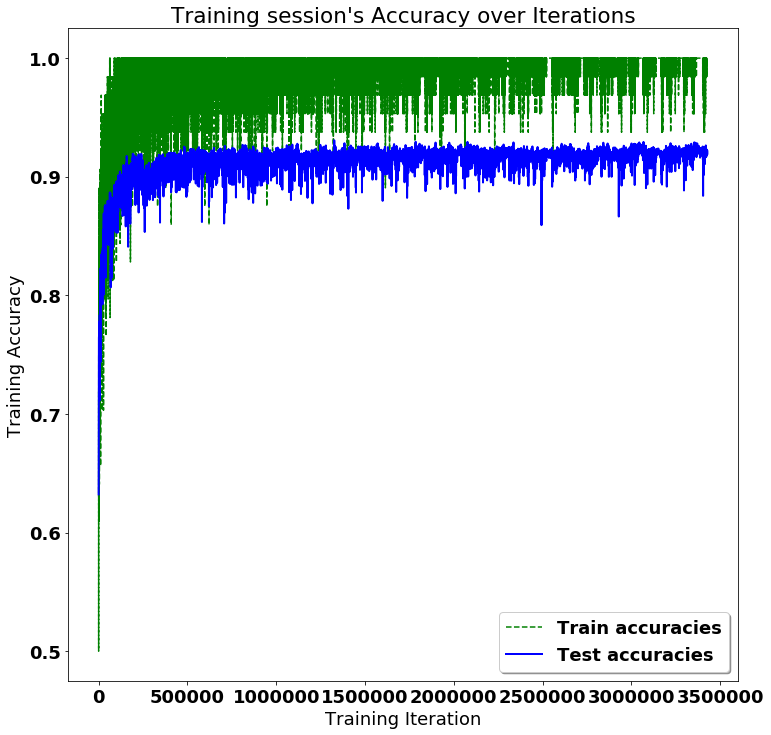

Testing Accuracy: 92.19735860824585%

Precision: 93.67870466167491%
Recall: 92.1973565635326%
f1_score: 92.43471722659206%

Confusion Matrix:
Created using test set of 26632 datapoints, normalised to % of each class in the test dataset


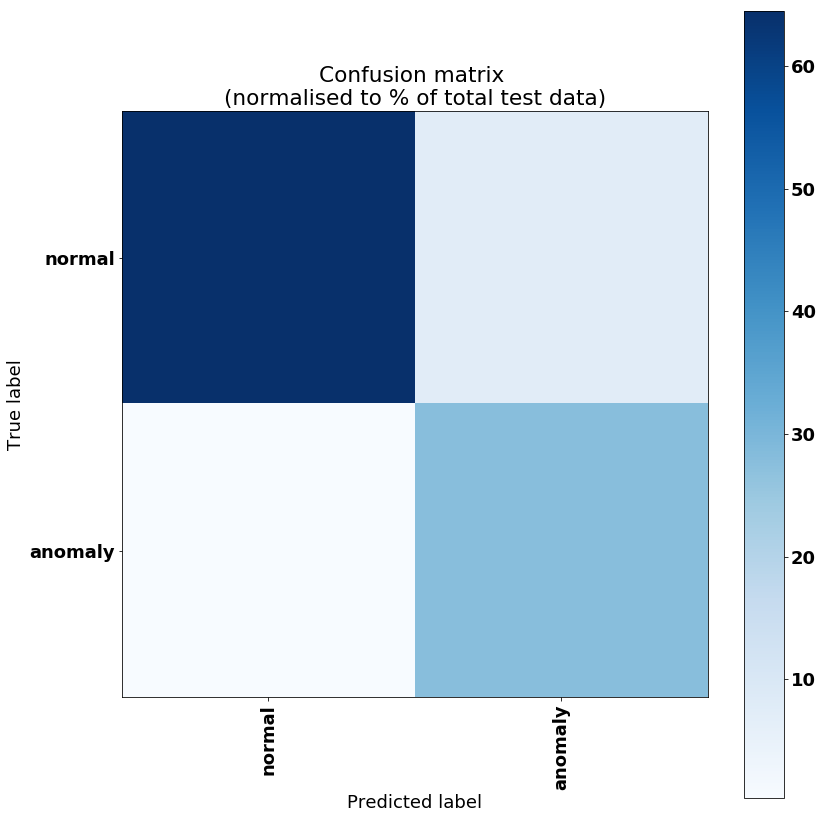

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.63220936, 0.6521102, 0.7596876, 0.7642686, 0.7655452, 0.75713426, 0.77455693, 0.76580805, 0.7767723, 0.77793634, 0.7562331, 0.7791754, 0.78353107, 0.71151245, 0.76329225, 0.7486858, 0.8081631, 0.78345597, 0.7577726, 0.7996771, 0.78890055, 0.82280713, 0.8151472, 0.7716657, 0.74395466, 0.82040405, 0.8298288, 0.8343346, 0.81372035, 0.79442024, 0.8023806, 0.7950961, 0.8240087, 0.8220562, 0.8222064, 0.8284395, 0.83516073, 0.8180009, 0.8319691, 0.83632475, 0.8146215, 0.82051665, 0.79243016, 0.81019074, 0.83523583, 0.83981675, 0.82288224, 0.80681133, 0.8235206, 0.8508561, 0.8549114, 0.83947885, 0.84349656, 0.83106786, 0.84627515, 0.80688643, 0.8689922, 0.80072844, 0.8623836, 0.8599429, 0.8475143, 0.85029286, 0.8420697, 0.8507059, 0.8636227, 0.8530715, 0.8374136, 0.87143284, 0.8750751, 0.84090567, 0.87143284, 0.86910486, 0.8639606, 0.876164, 0.86974317, 0.87173325, 0.8712076, 0.8628717, 0.8497672, 0.8149219, 0.8452238, 0.8448858, 0.860769, 0.8581406, 0.86628866, 0.85896665, 0.84518623, 0.85

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Writing 1296264 bytes to LSTM.md


## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
